# Univariate Time Series Analysis

### Kevin Sheppard

* Forcasting
  * AR(1)
  * AR(1) direct
* Forecasting recursively
* Cross-validation
* Absolute forecast eval
* Relaitve forecast evaluation
* Seasonal DIfferencing
* Seasonal Summies + ARMA
* SARIMA
* Unit Root testing


In [1]:
import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix as pd_scatter_matrix
from scipy import stats
from statsmodels.tsa.api import SARIMAX

mfe.full_setup()
mfe.outputs["pres"]()
DEFAULT_FIGSIZE = (32, 15)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)


LAST_COLOR_INDEX = 0
MAX_COLOR_INDEX = 8


def figsize(x=DEFAULT_FIGSIZE[0], y=DEFAULT_FIGSIZE[1]):
    if x <= 0:
        x += DEFAULT_FIGSIZE[0]
    if y <= 0:
        y += DEFAULT_FIGSIZE[1]
    plt.rc("figure", figsize=(x, y))


def plot(s: pd.Series, y=DEFAULT_FIGSIZE[1]):
    global LAST_COLOR_INDEX
    figsize(y=y)
    fig, ax = plt.subplots(1, 1)
    if isinstance(s, pd.Series):
        s.plot(ax=ax, legend=False, color=mfe.colors[LAST_COLOR_INDEX])
    else:
        s.plot(ax=ax, legend=False)
        fig.legend(frameon=False)
    LAST_COLOR_INDEX += 1
    LAST_COLOR_INDEX = LAST_COLOR_INDEX % MAX_COLOR_INDEX
    ax.set_xlabel(None)
    ax.set_xlim(s.index[0], s.index[-1])
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()


def pretty(s):
    from IPython.display import HTML, display

    if not isinstance(s, pd.Series):
        return display(HTML(f"<span>{s}</span>"))

    df = pd.DataFrame(s)
    if df.columns[0] == 0:
        df.columns = [""]
    return df


def summary(res, idx=(1,)):
    from IPython.display import HTML, display

    summ = res.summary()
    for i in idx:
        html = summ.tables[i]._repr_html_()
        if i == 0:
            html = html.split("</tr>")
            html = "</tr>".join(html[:-8] + html[-1:])
            html = html.replace("<caption>OLS Regression Results</caption>", "")
        display(HTML(html))
    return None


figsize()

with pd.HDFStore("time-series-data.h5", mode="r") as store:
    curve = store.get("curve")
    default = store.get("default")
    housing = store.get("housing")
    indpro = store.get("indpro")
    orig = store.get("orig")
    seasonal = store.get("seasonal")
    sim = store.get("sim")
    uscons = store.get("uscons")
    vwm = store.get("vwm")
housing_yoy = np.log(orig.HOUSTNSA).diff(12).dropna()
housing_raw = np.log(orig.HOUSTNSA).dropna()
housing_yoy = housing_yoy.reindex_like(housing)
housing_raw = housing_raw.reindex_like(housing)
m2_growth = np.log(orig.M2SL).diff().dropna().reindex_like(housing)
vix = np.log(orig.VXOCLSx).dropna()
series = {
    "curve": curve,
    "default": default,
    "housing": housing,
    "indpro": indpro,
    "orig": orig,
    "seasonal": seasonal,
    "sim": sim,
    "uscons": uscons,
    "vwm": vwm,
    "m2_growth": m2_growth,
}

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf


def acf_pacf_plot(y, lags, correct=False, title=None, size=DEFAULT_FIGSIZE[1]):
    figsize(y=size)
    a = acf(y, nlags=lags, fft=True)
    p = pacf(y, nlags=lags)
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    t = y.shape[0]
    ax[0].bar(x, a[1:])
    ax[1].bar(x, p[1:], color=mfe.colors[1])
    a_ci = p_ci = 1.96 * np.ones_like(a[1:]) / np.sqrt(t)
    if correct:
        a_ci = 1.96 * (1 + np.cumsum(a[:-1] ** 2)) / np.sqrt(t)
    x[0] = 0.5
    x[-1] = lags + 0.5
    ax[0].plot(x, a_ci, "k--", x, -a_ci, "k--")
    ax[1].plot(x, p_ci, "k--", x, -p_ci, "k--")
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Autocorrelation")
    ax[1].set_title("Partial Autocorrelation")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

In [3]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_lm


def lb_plot(x, lags, title=None):
    df = acorr_ljungbox(resid, lags, return_df=True)
    stat = df.iloc[:, 0]
    pval = df.iloc[:, 1]
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    ax[0].bar(x, stat)
    cv = stats.chi2.ppf(0.95, np.arange(1, lags + 1))
    ax[0].plot(x, cv, "k--")
    ax[1].bar(x, pval, color=mfe.colors[1])
    cv[:] = 0.05
    x[0] = 0.0
    x[-1] = lags + 1
    ax[1].plot(x, cv, "k--")
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Q Stat")
    ax[1].set_title("P-value")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)


def lm_plot(x, lags, title=None):
    d = {}
    for i in range(1, lags + 1):
        stat, pval, _, _ = acorr_lm(resid, nlags=i, cov_type="HC0", autolag=None)
        pval = float(pval)
        s = pd.Series([stat, pval], index=["stat", "pval"])
        d[i] = s
    df = pd.DataFrame(d).T

    stat = df.iloc[:, 0]
    pval = df.iloc[:, 1]
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    ax[0].bar(x, stat)
    cv = stats.chi2.ppf(0.95, np.arange(1, lags + 1))
    ax[0].plot(x, cv, "k--")
    ax[1].bar(x, pval, color=mfe.colors[1])
    cv[:] = 0.05
    x[0] = 0.0
    x[-1] = lags + 1
    ax[1].plot(x, cv, "k--")
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("LM Stat")
    ax[1].set_title("P-value")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)

In [4]:
from pandas import IndexSlice


def ic_plot(aic, bic):
    figsize(y=DEFAULT_FIGSIZE[1] - 2)
    fig, ax = plt.subplots(1, 2)
    for i in range(3):
        aic.loc[(slice(None), i)].plot(
            ax=ax[0], linestyle="none", marker="s", markersize=24
        )
        xl = aic.loc[(slice(None), i)].index
    ax[0].plot(
        [aic.idxmin()[0]],
        [aic.min()],
        linestyle="none",
        marker="o",
        markersize=64,
        color=mfe.colors[7],
        zorder=-3,
        alpha=0.33,
    )
    for i in range(3):
        bic.loc[(slice(None), i)].plot(
            ax=ax[1], linestyle="none", marker="s", markersize=24, label=f"Q={i}"
        )
    ax[1].plot(
        [bic.idxmin()[0]],
        [bic.min()],
        linestyle="none",
        marker="o",
        markersize=64,
        color=mfe.colors[7],
        zorder=-3,
        alpha=0.33,
    )
    ax[1].legend(frameon=False, loc="lower right")
    ax[0].set_title("AIC")
    ax[0].set_xticks(xl)
    ax[1].set_xticks(xl)
    ax[1].set_title("BIC")
    yl = ax[0].get_ylim()
    ax[0].set_ylim(2 * aic.min() - aic.median(), 2 * aic.median() - aic.min())
    ax[1].set_ylim(2 * bic.min() - bic.median(), 2 * bic.median() - bic.min())
    ax[0].set_xlabel("P")
    ax[1].set_xlabel("P")
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

# Seasonality

* A seasonal time series has a deterministic pattern that repeats on an annual basis

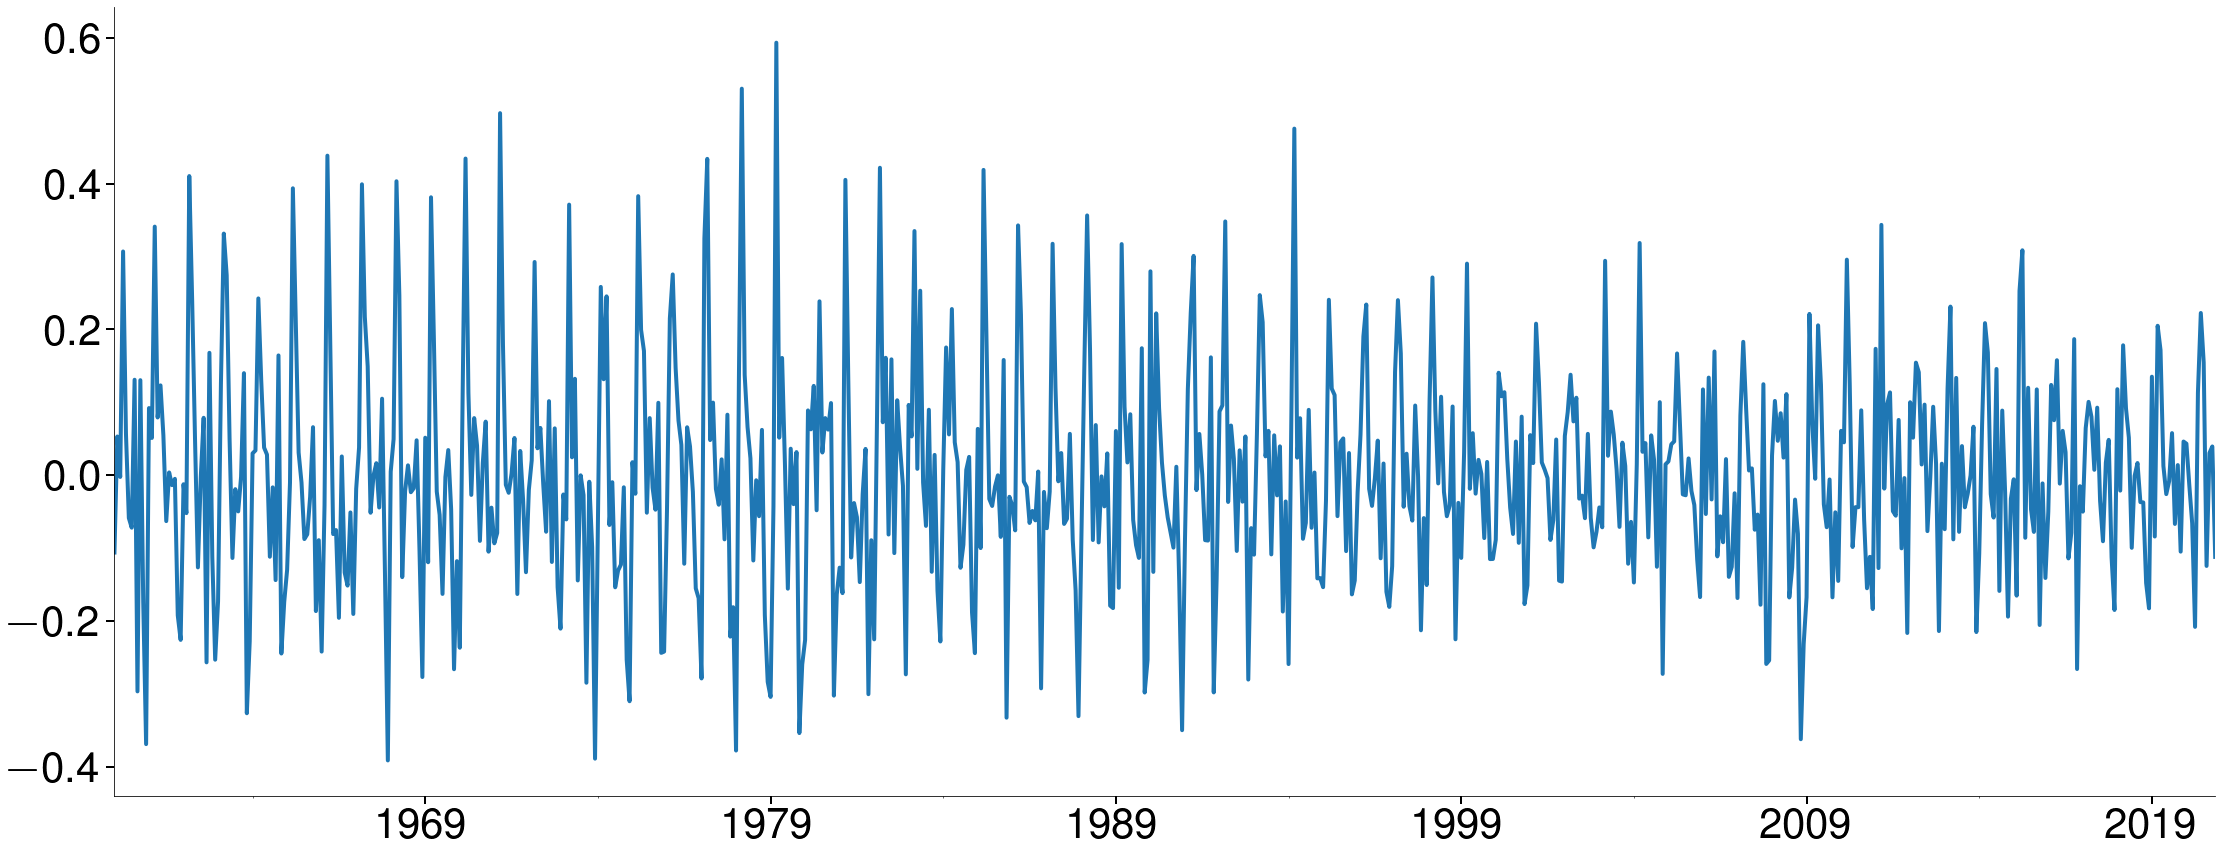

In [5]:
plot(housing, y=-2)

# Seasonal Autocorrelation Pattern

* Seasonal data has dynamics at the annual frequency

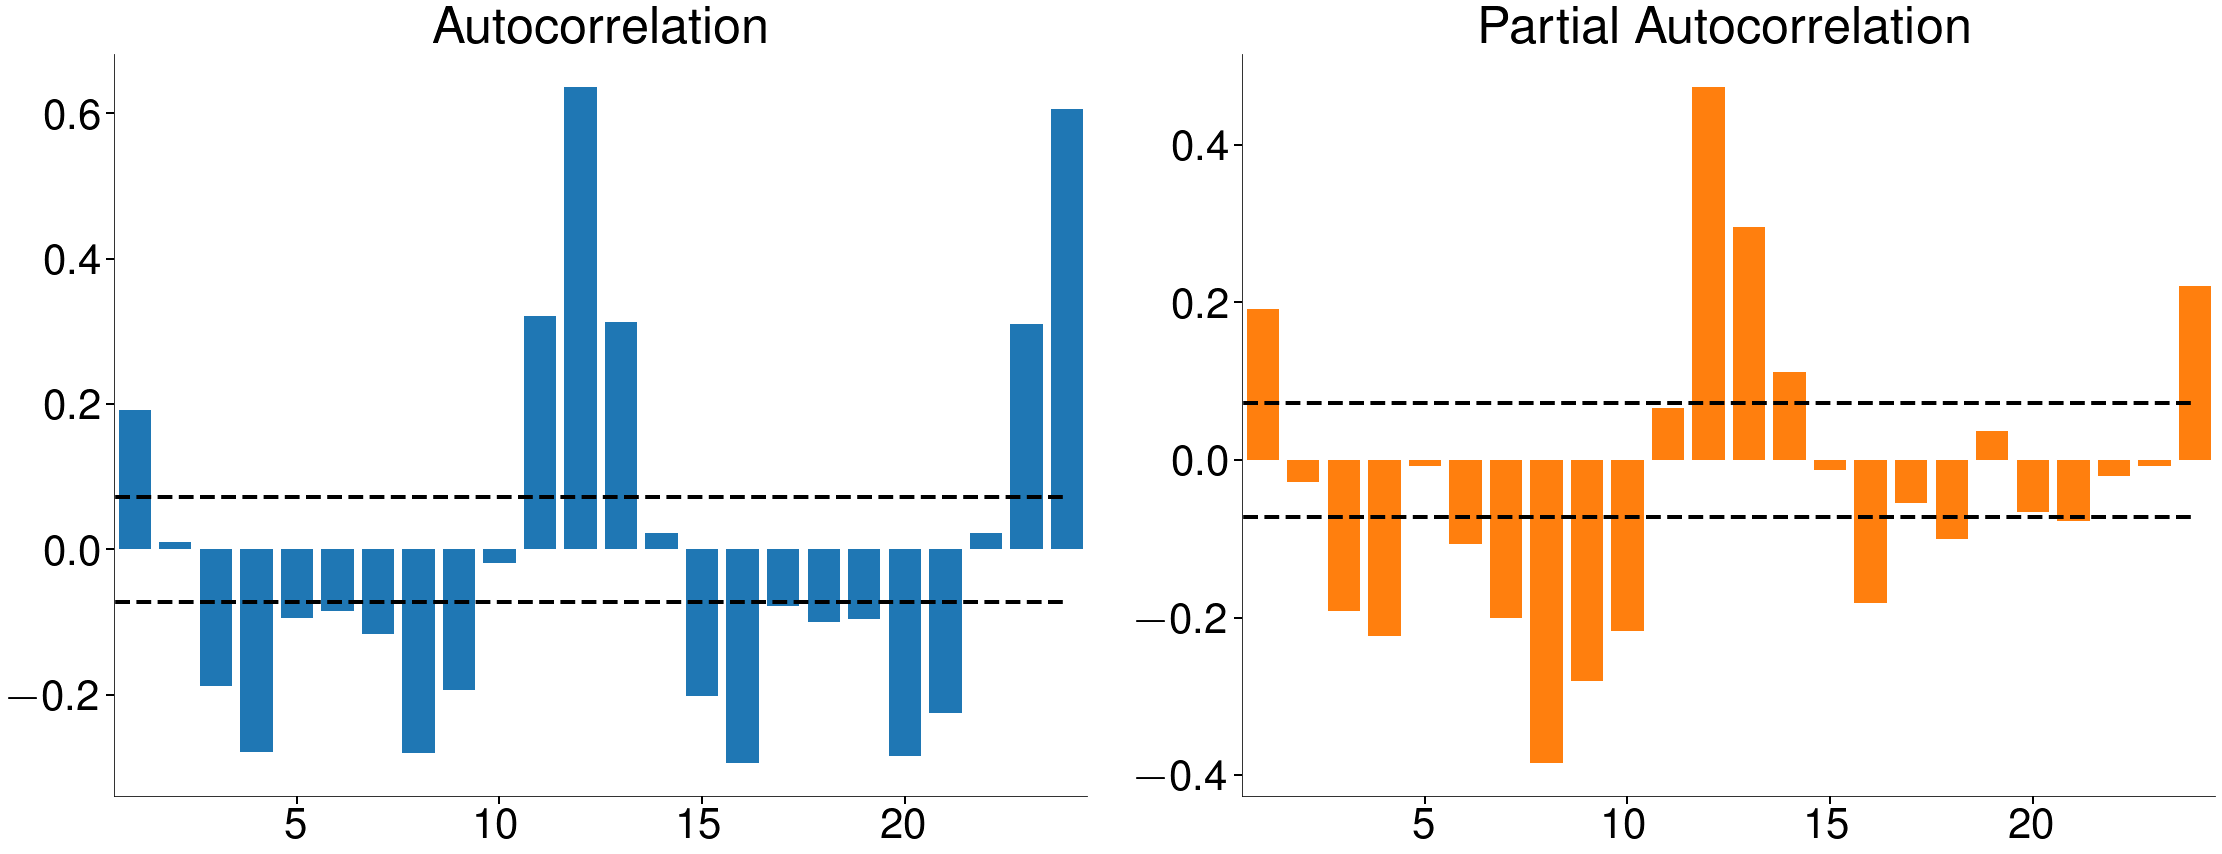

In [6]:
acf_pacf_plot(housing, 24, size=-2)

# Seasonal Differencing

* Seasonal differencing differences using the seasonal period $s$

$$ \Delta_{s} Y_t = Y_t - Y_{t-s} $$

* Can reduce or eliminate seasonalities

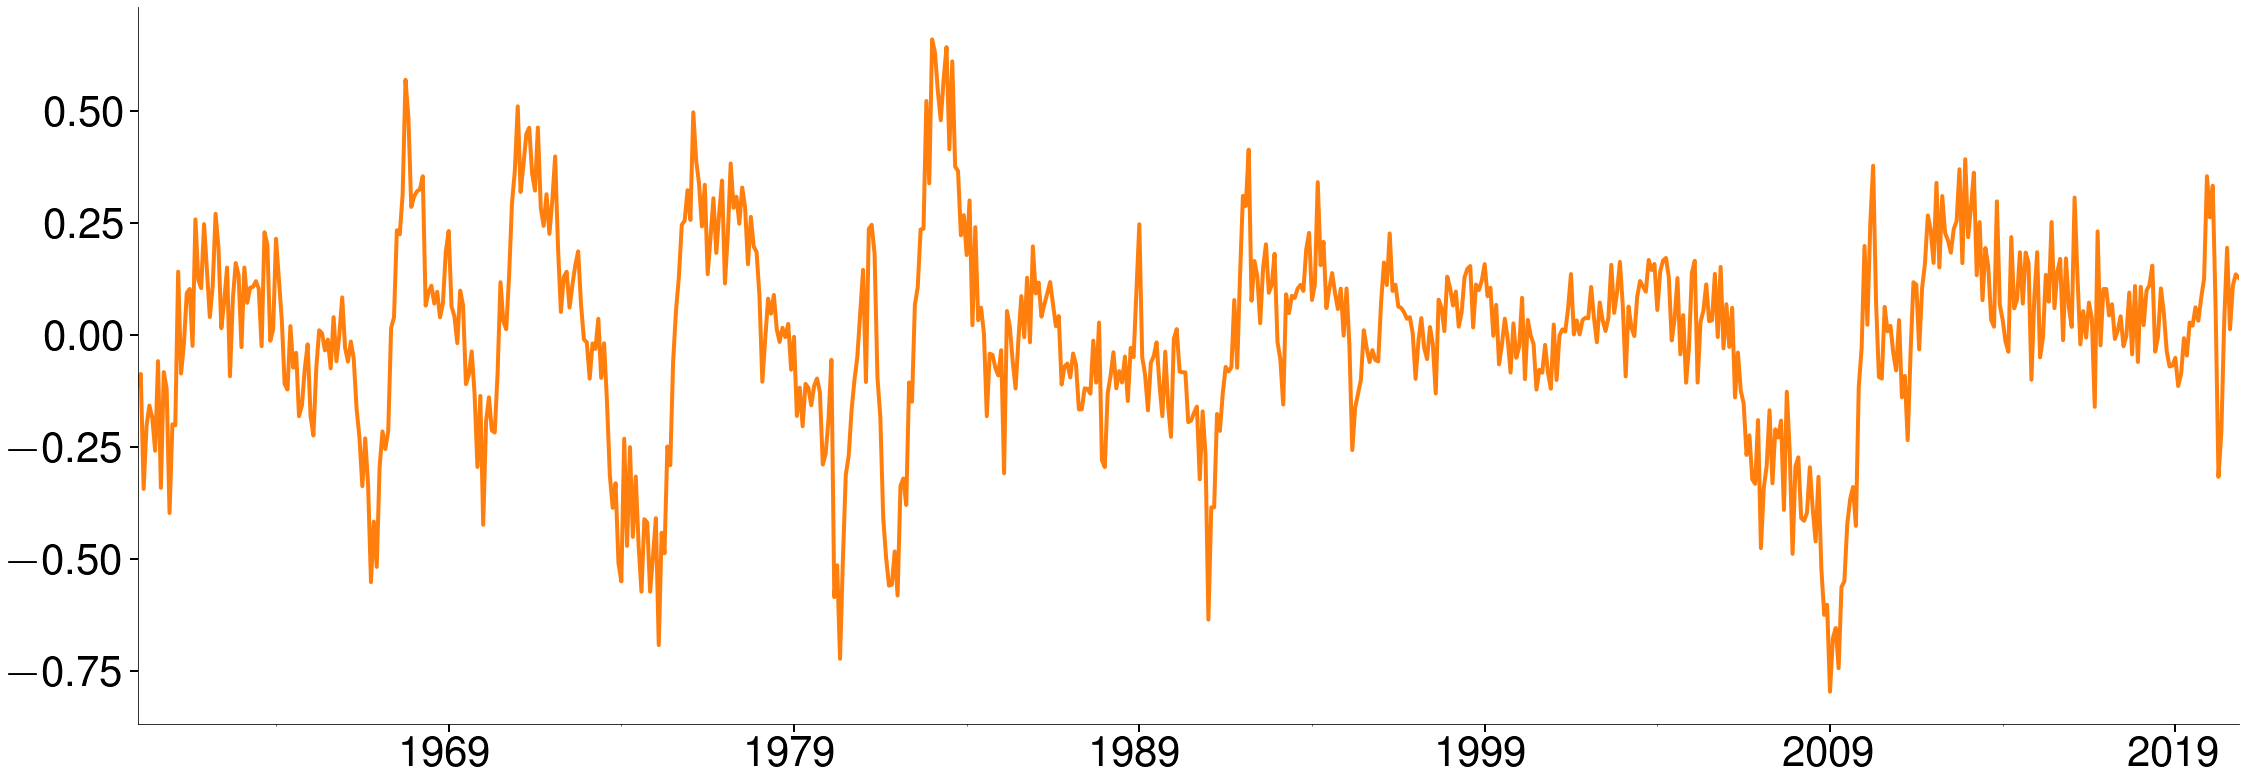

In [7]:
plot(housing_yoy, y=12)

# Seasonal Difference Autocorrelation Pattern

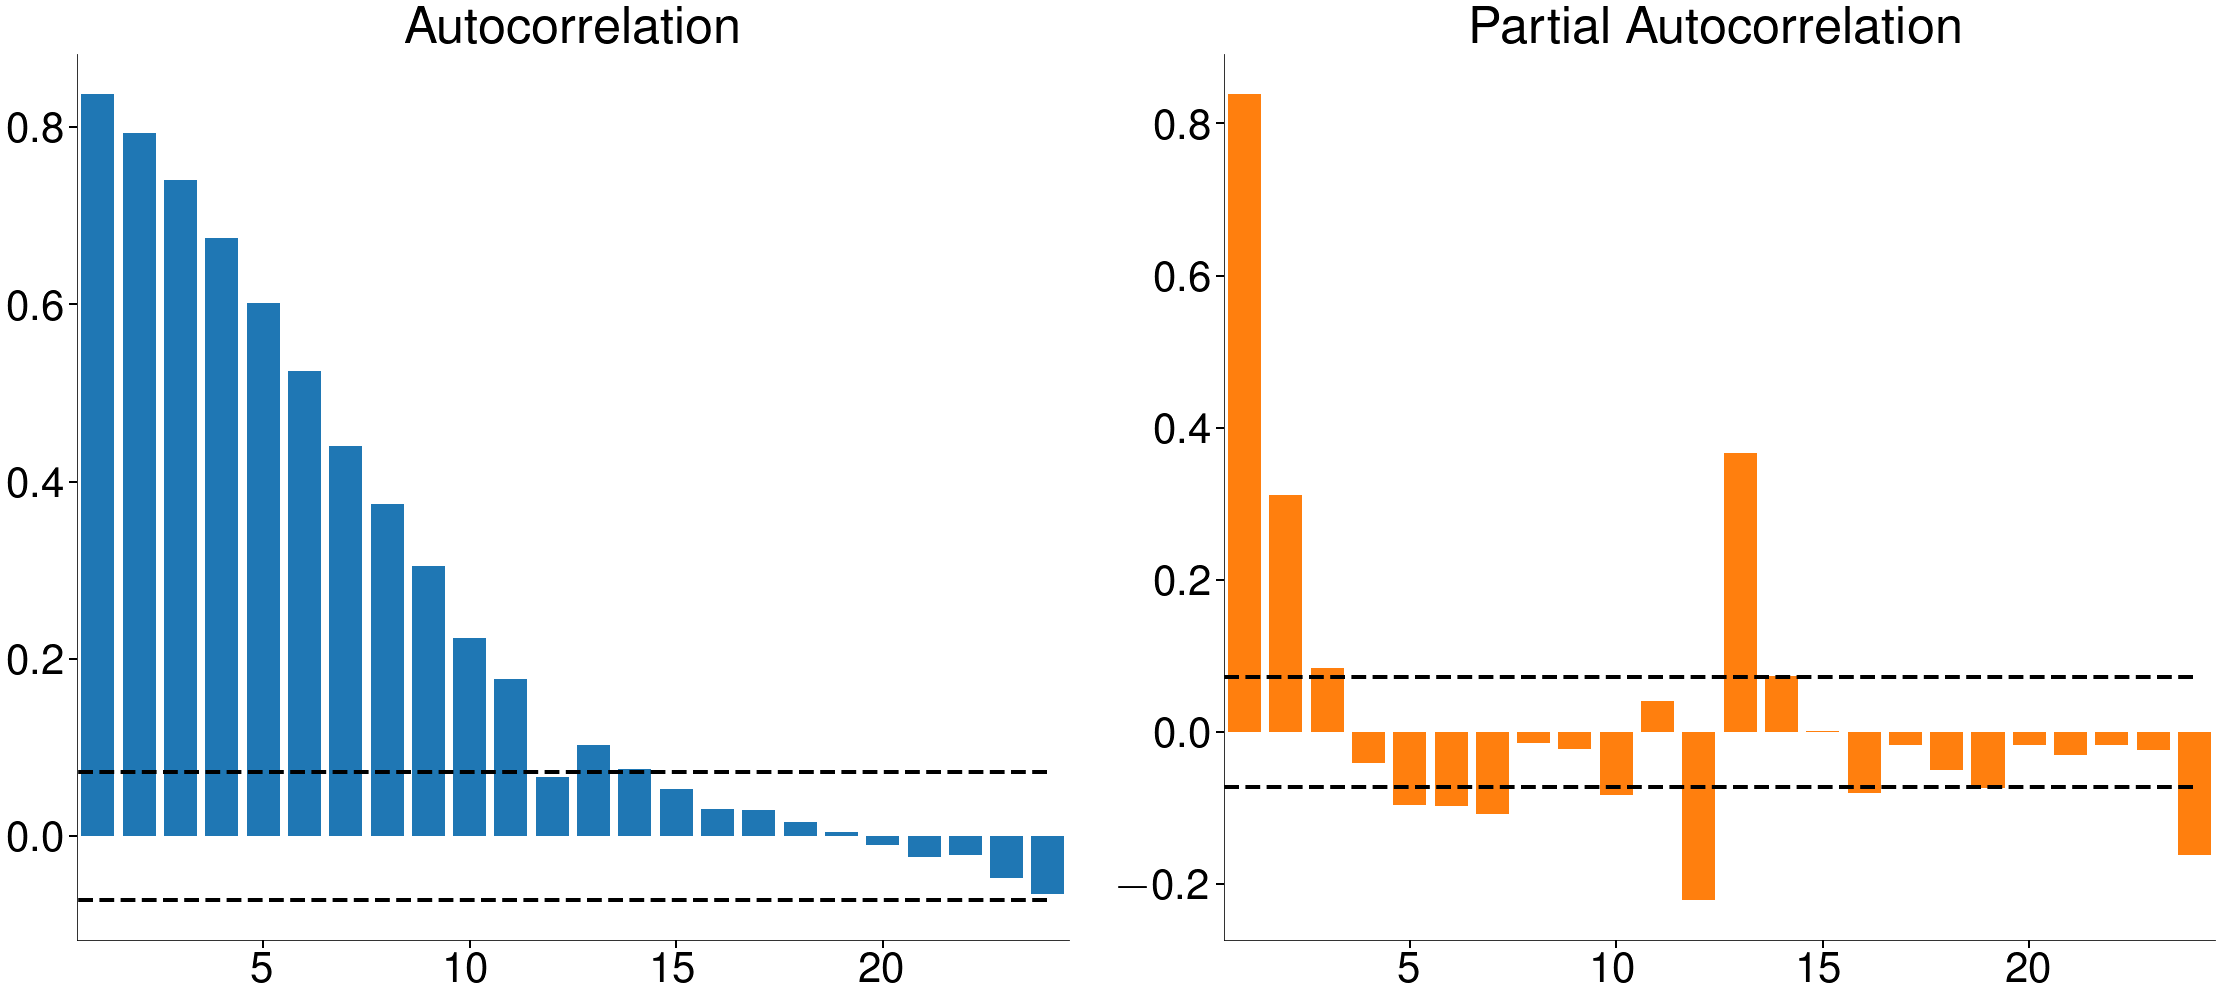

In [8]:
acf_pacf_plot(housing_yoy, 24)

# Modeling Seasonal Differences

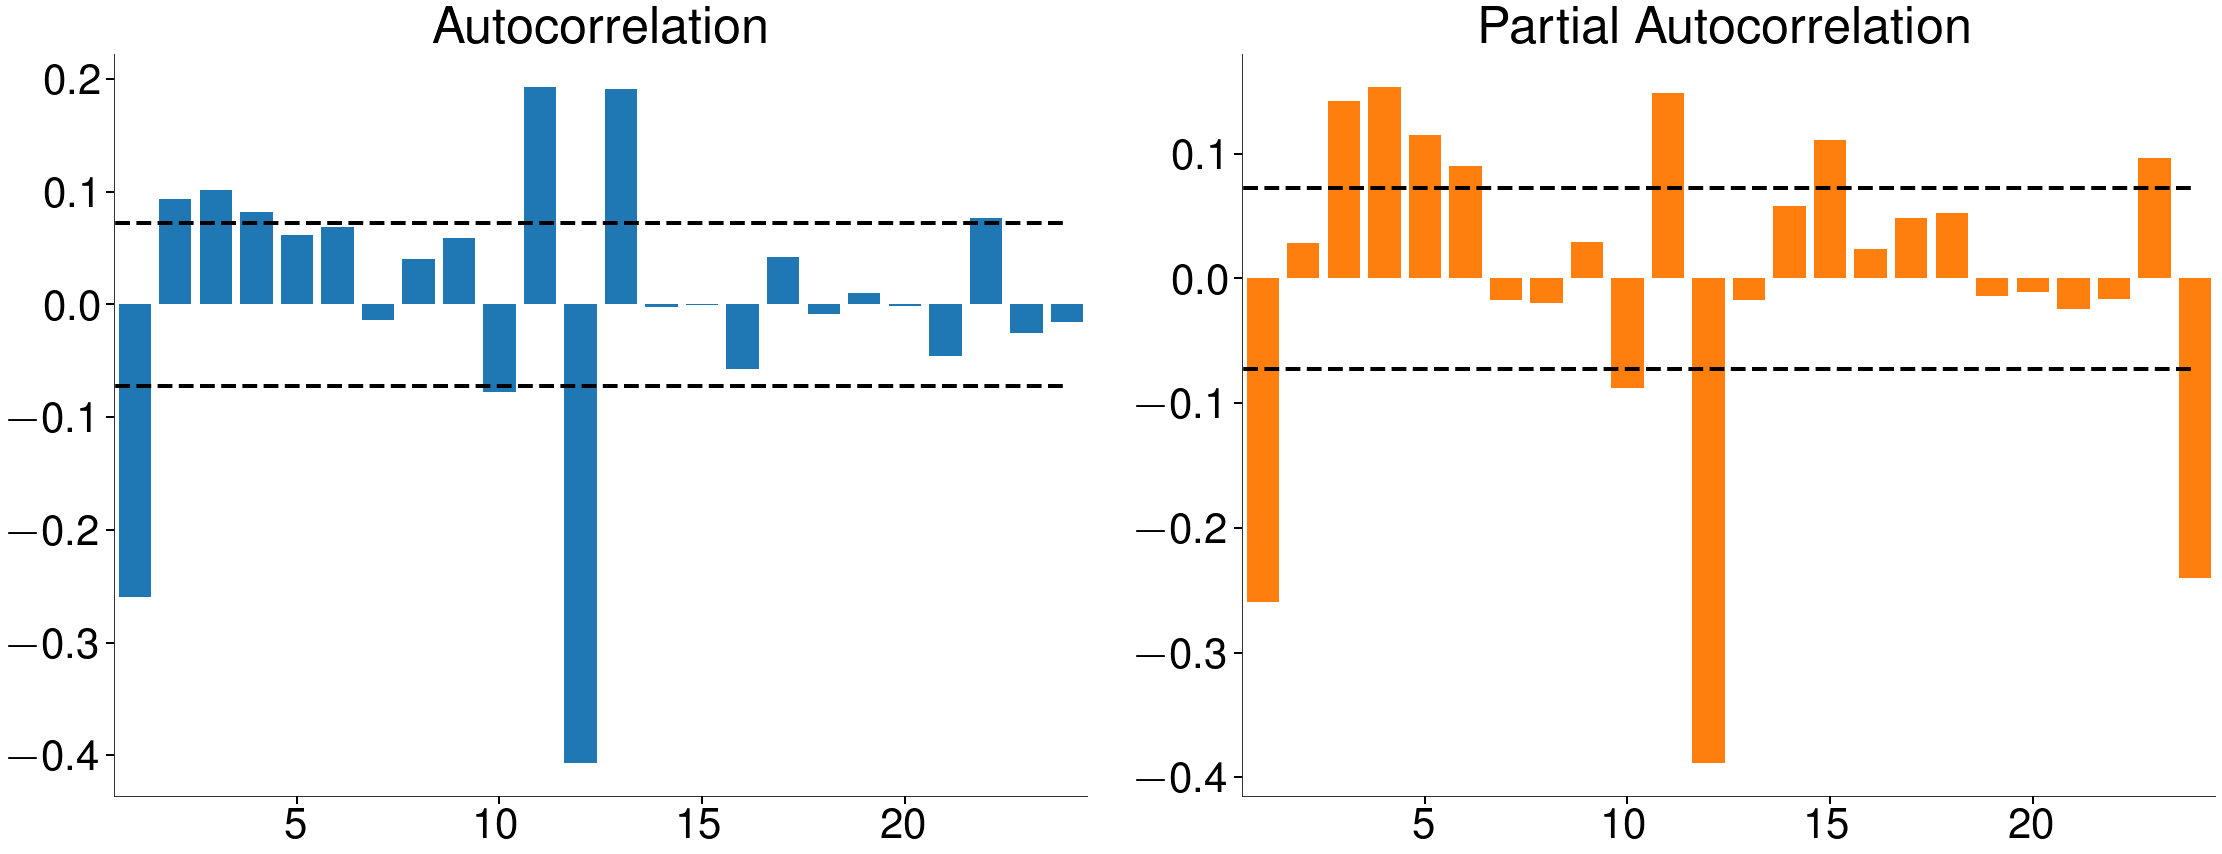

In [9]:
res = SARIMAX(housing_yoy, order=(1, 0, 0)).fit()
resids = res.resid.iloc[1:]
acf_pacf_plot(resids, 24, size=-2)

# Seasonal ARMA Models

* SARMA models data at both the observational and seasonal frequency
* In lag polynomial representation

$$ (1-\phi_1 L -\phi_2 L^2) Y_t = \phi_0 + (1+\theta_s L^s)\epsilon_t $$

* In standard ARMA representation

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} +\phi_2 Y_{t-2} \theta_s \epsilon_{t-s}  + \epsilon_t $$

$$ SARMA$(P,0,Q)\times(P_s,0,Q_s,s) $$

In [10]:
res = SARIMAX(housing_yoy, order=(2, 0, 0), seasonal_order=(0, 0, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6809,0.034,20.284,0.000,0.615,0.747
ar.L2,0.2824,0.034,8.233,0.000,0.215,0.350
ma.S.L12,-0.8795,0.017,-50.520,0.000,-0.914,-0.845
sigma2,0.0083,0.000,21.791,0.000,0.008,0.009


# SARMA Residual Diagnostics

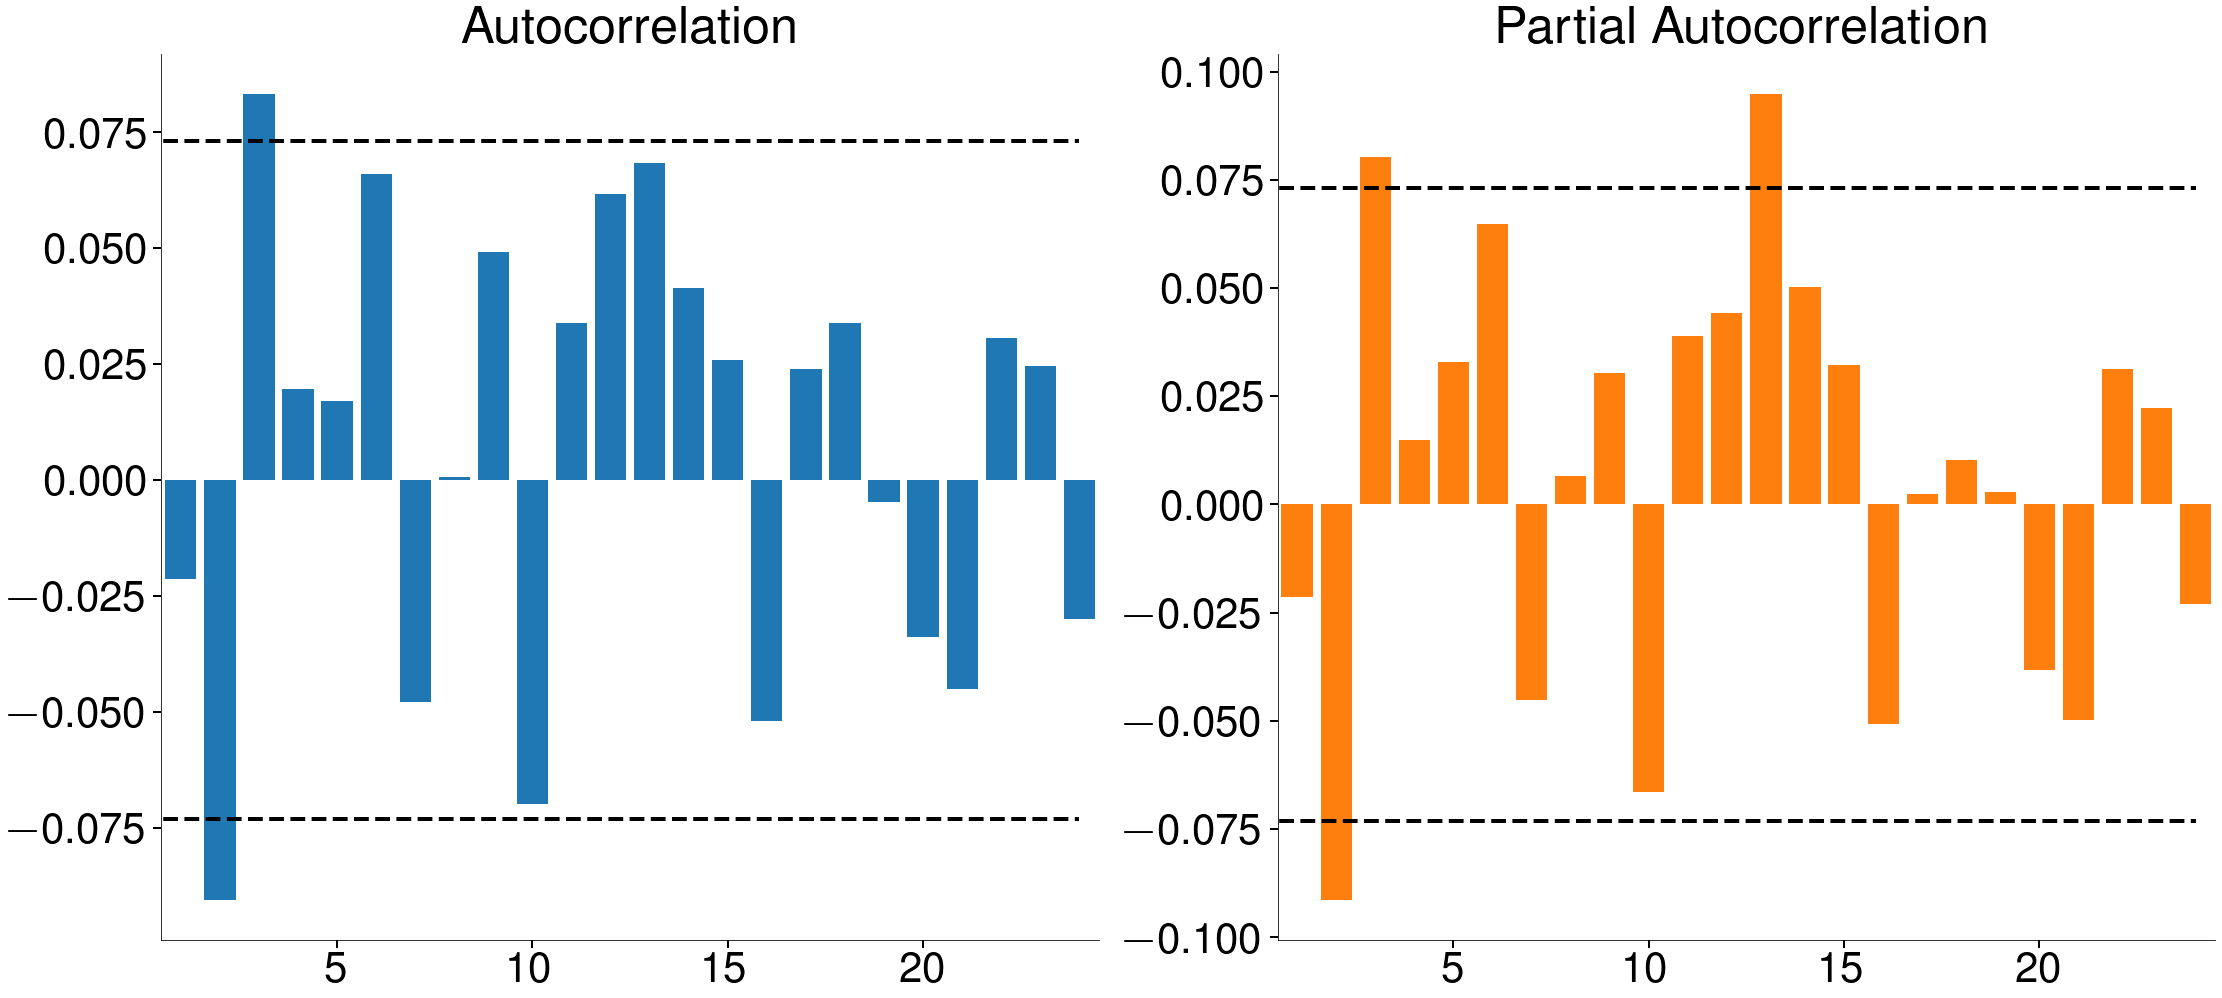

In [11]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Extended Dynamics $(1,0,1)\times(1,0,1)_{12}$

* In lag polynomial representation

$$ (1-\phi_1 L)(1-\phi_s L^s)Y_t = \phi_0 + (1+\theta_1 L)(1+\theta_s L^s)\epsilon_t $$

* In standard ARMA representation

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} +\phi_s Y_{t-s} - \phi_1\phi_s Y_{t-s-1} + \theta_1 \epsilon_{t-1} +\theta_s \epsilon_{t-s} + \theta_1\theta_s \epsilon_{t-s-1} + \epsilon_t $$

In [12]:
res = SARIMAX(housing_raw, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9994,0.001,1441.218,0.000,0.998,1.001
ma.L1,-0.3196,0.031,-10.367,0.000,-0.380,-0.259
ar.S.L12,0.9987,0.001,1469.955,0.000,0.997,1.000
ma.S.L12,-0.8957,0.016,-54.402,0.000,-0.928,-0.863
sigma2,0.0083,0.000,22.277,0.000,0.008,0.009


# Extended Model Residual Diagnostics

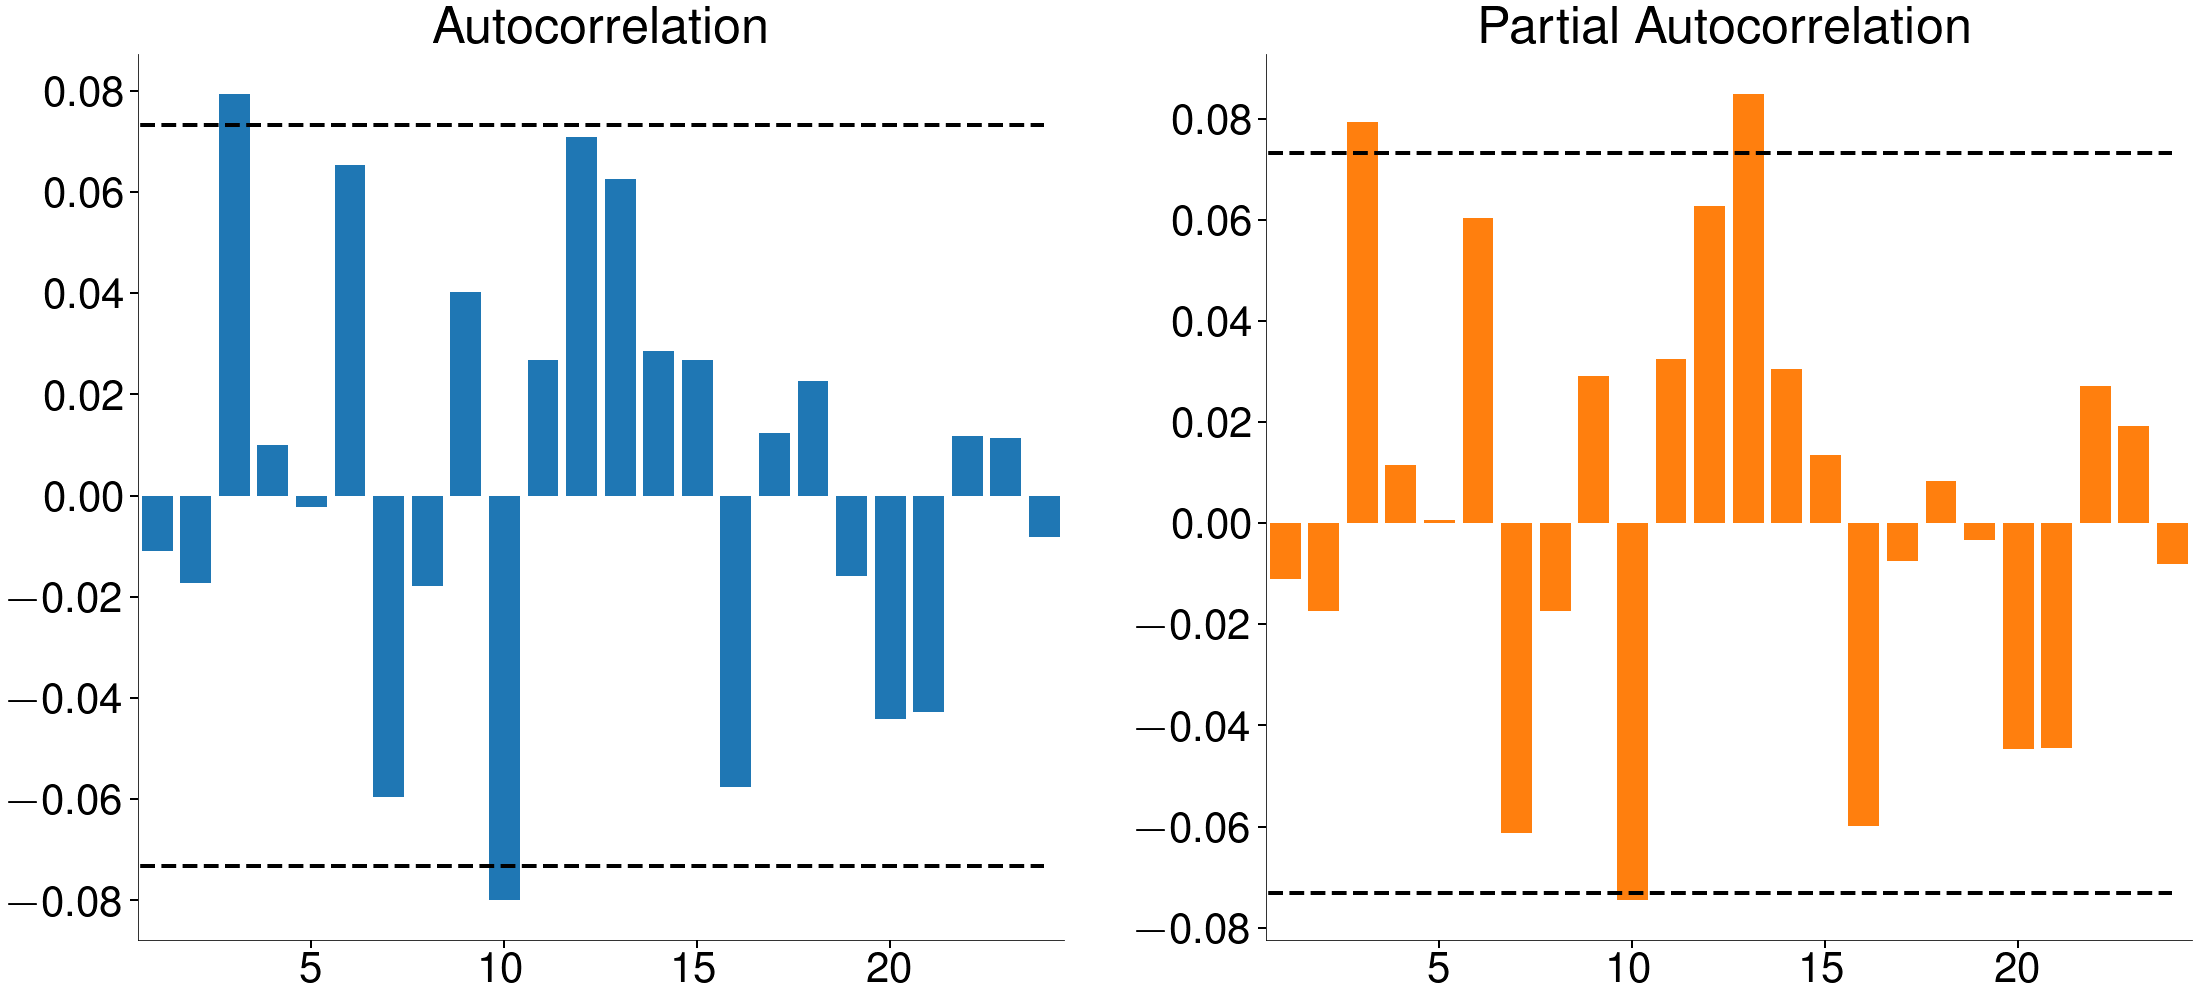

In [13]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Incorporating differencing

* SARIMA - Seasonal Autoregressive Integrated Moving Average

$$ \text{SARIMA} (P,D,Q)\times(P_s,D_s,Q_s,s)$$

$$ \Phi(L)\Phi_s(L)(1-L)^D(1-L^s)^{D_s} Y_t = \phi_0 + \Theta(L)\Theta_s(L)\epsilon_t $$

* **AR**
$$\Phi(L) = $1-\phi_1 L - \phi_2 L^2 - \ldots -\phi_P L^P$$
* **Seasonal AR**: $$\Phi_s(L) = 1-\phi_s L^s - \phi_{2s} L^{2s} - \ldots -\phi_{P_s s} L^{P_s s}$$
* **MA**: $$\Theta(L) = 1+\theta_1 L + \theta_2 L^2 + \ldots +\phi_Q L^Q$$
* **Seasonal MA**: $$\Theta_s(L) = 1+\theta_s L^s + \theta_{2s} L^{2s} + \ldots +\theta_{Q_s s} L^{Q_s s}$$

# Estimating SARIMA Models

In [14]:
res = SARIMAX(housing_raw, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9777,0.008,126.932,0.000,0.963,0.993
ma.L1,-0.3128,0.033,-9.352,0.000,-0.378,-0.247
ma.S.L12,-0.8775,0.018,-48.061,0.000,-0.913,-0.842
sigma2,0.0083,0.000,21.771,0.000,0.008,0.009


# SARIMA$(1,0,1)\times(0,1,1)_{12}$ Residual Analysis

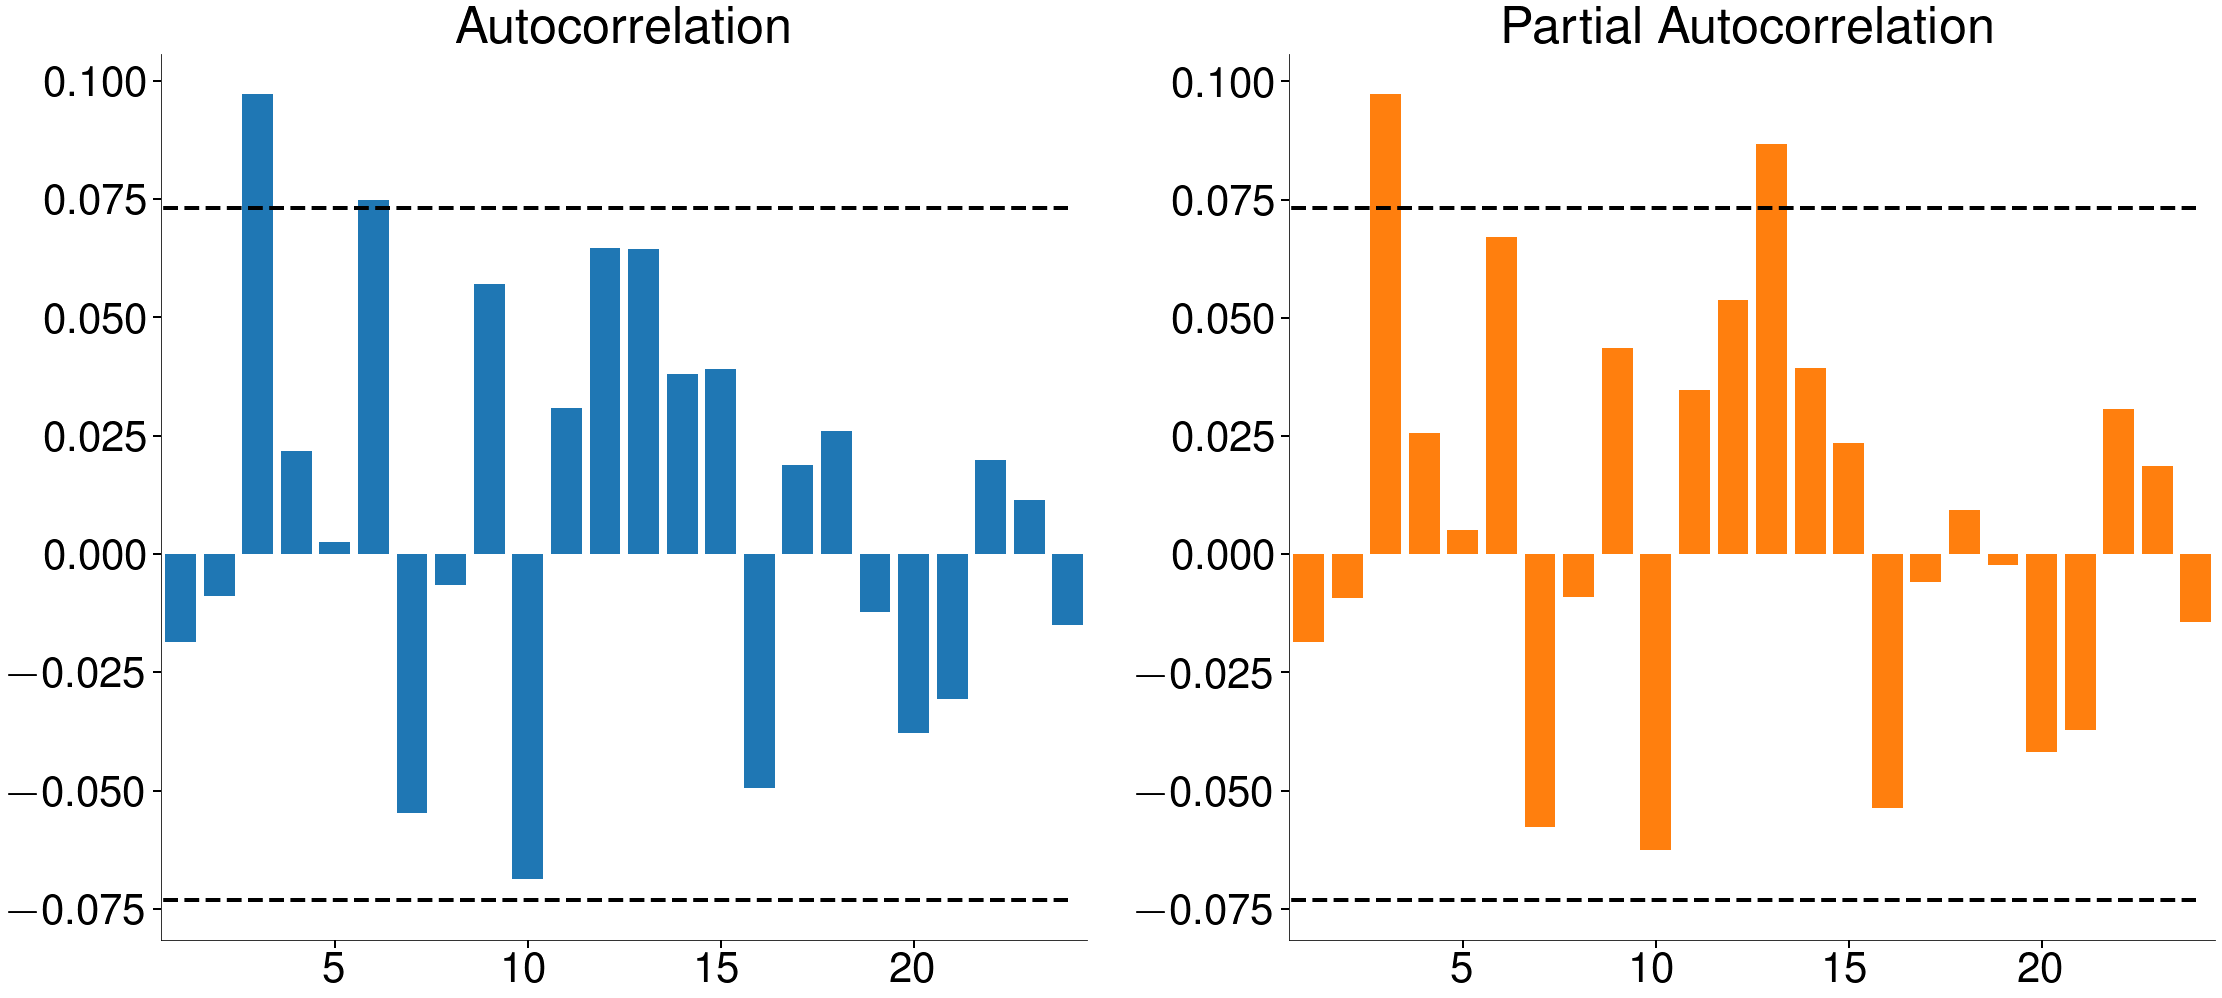

In [15]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Enforcing Unit Roots

* Set both differences to 1
  * $D=1$
  * $D_s=1$

* Model is

$$ (1-L)(1-L^s)Y_t = \theta_s \epsilon_{t-s} + \epsilon_t $$
$$ \Delta\Delta_s Y_t = \theta_s \epsilon_{t-s} + \epsilon_t $$

In [16]:
res = SARIMAX(housing_raw, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.3246,0.031,-10.362,0.000,-0.386,-0.263
ma.S.L12,-0.8774,0.019,-47.035,0.000,-0.914,-0.841
sigma2,0.0084,0.000,22.025,0.000,0.008,0.009


# Double Difference Residual Diagnostics

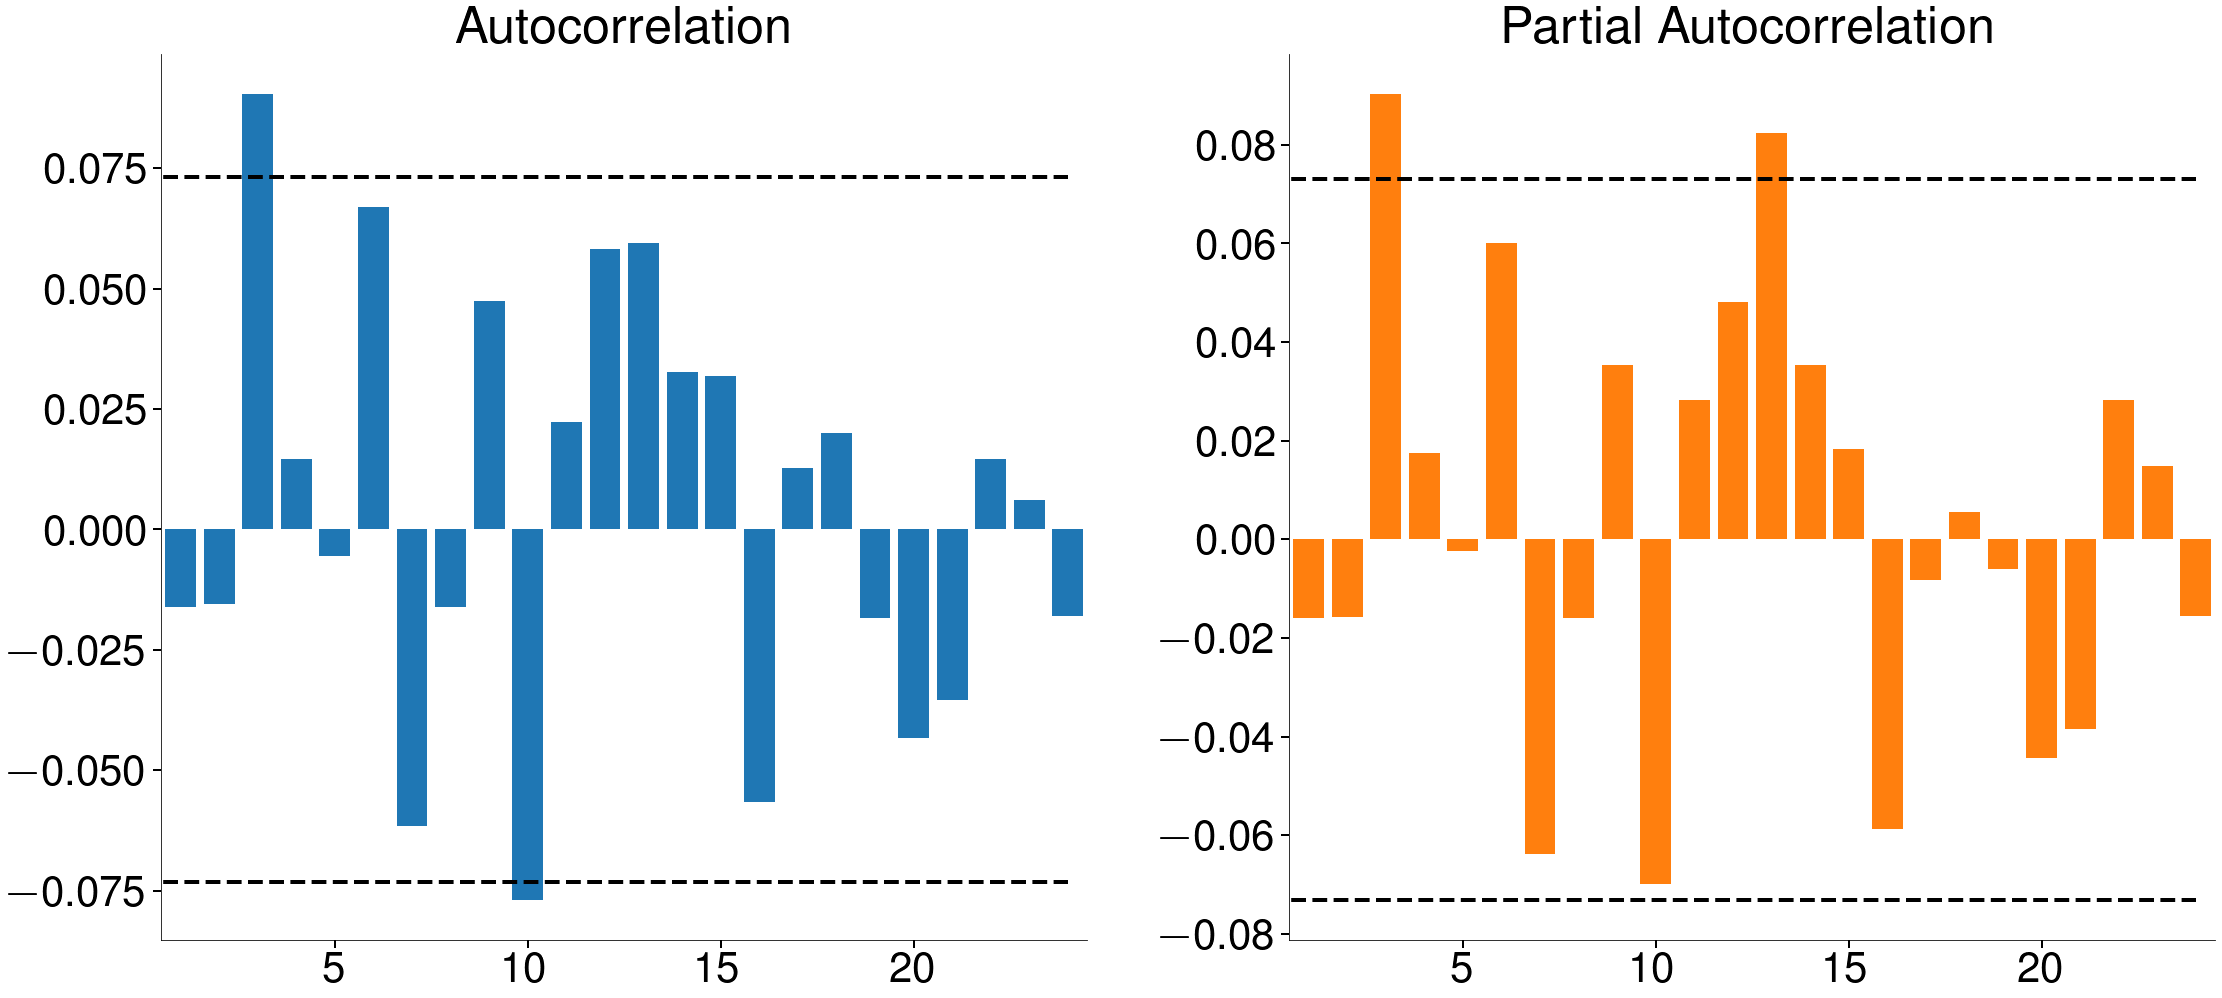

In [17]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Seasonal Dummies

* Alternative approach to SARIMA
* Model shifts as a deterministic processes
* One dummy for each of $s-1$ periods
  * Avoid dummy variable trap

In [18]:
month = housing_raw.index.strftime("%b")
dummies = pd.get_dummies(month)
dummies = dummies[
    ["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
]
dummies.index = housing_raw.index
dummies.head()

,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1960-01-01,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,0,0,0,1,0,0,0,0,0,0,0


# Incorporating Dummies

In [19]:
res = SARIMAX(housing_raw, order=(2, 1, 0), exog=dummies, trend="c").fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0002,0.004,0.048,0.962,-0.007,0.008
Feb,0.0358,0.012,2.965,0.003,0.012,0.059
Mar,0.3075,0.012,24.777,0.000,0.283,0.332
Apr,0.4289,0.015,29.516,0.000,0.400,0.457
May,0.4669,0.018,26.260,0.000,0.432,0.502
Jun,0.4697,0.019,25.308,0.000,0.433,0.506
Jul,0.4328,0.019,23.265,0.000,0.396,0.469
Aug,0.4117,0.019,22.227,0.000,0.375,0.448
Sep,0.3657,0.017,21.802,0.000,0.333,0.399
Oct,0.3921,0.015,26.252,0.000,0.363,0.421


# Seasonal Dummy Model Residuals

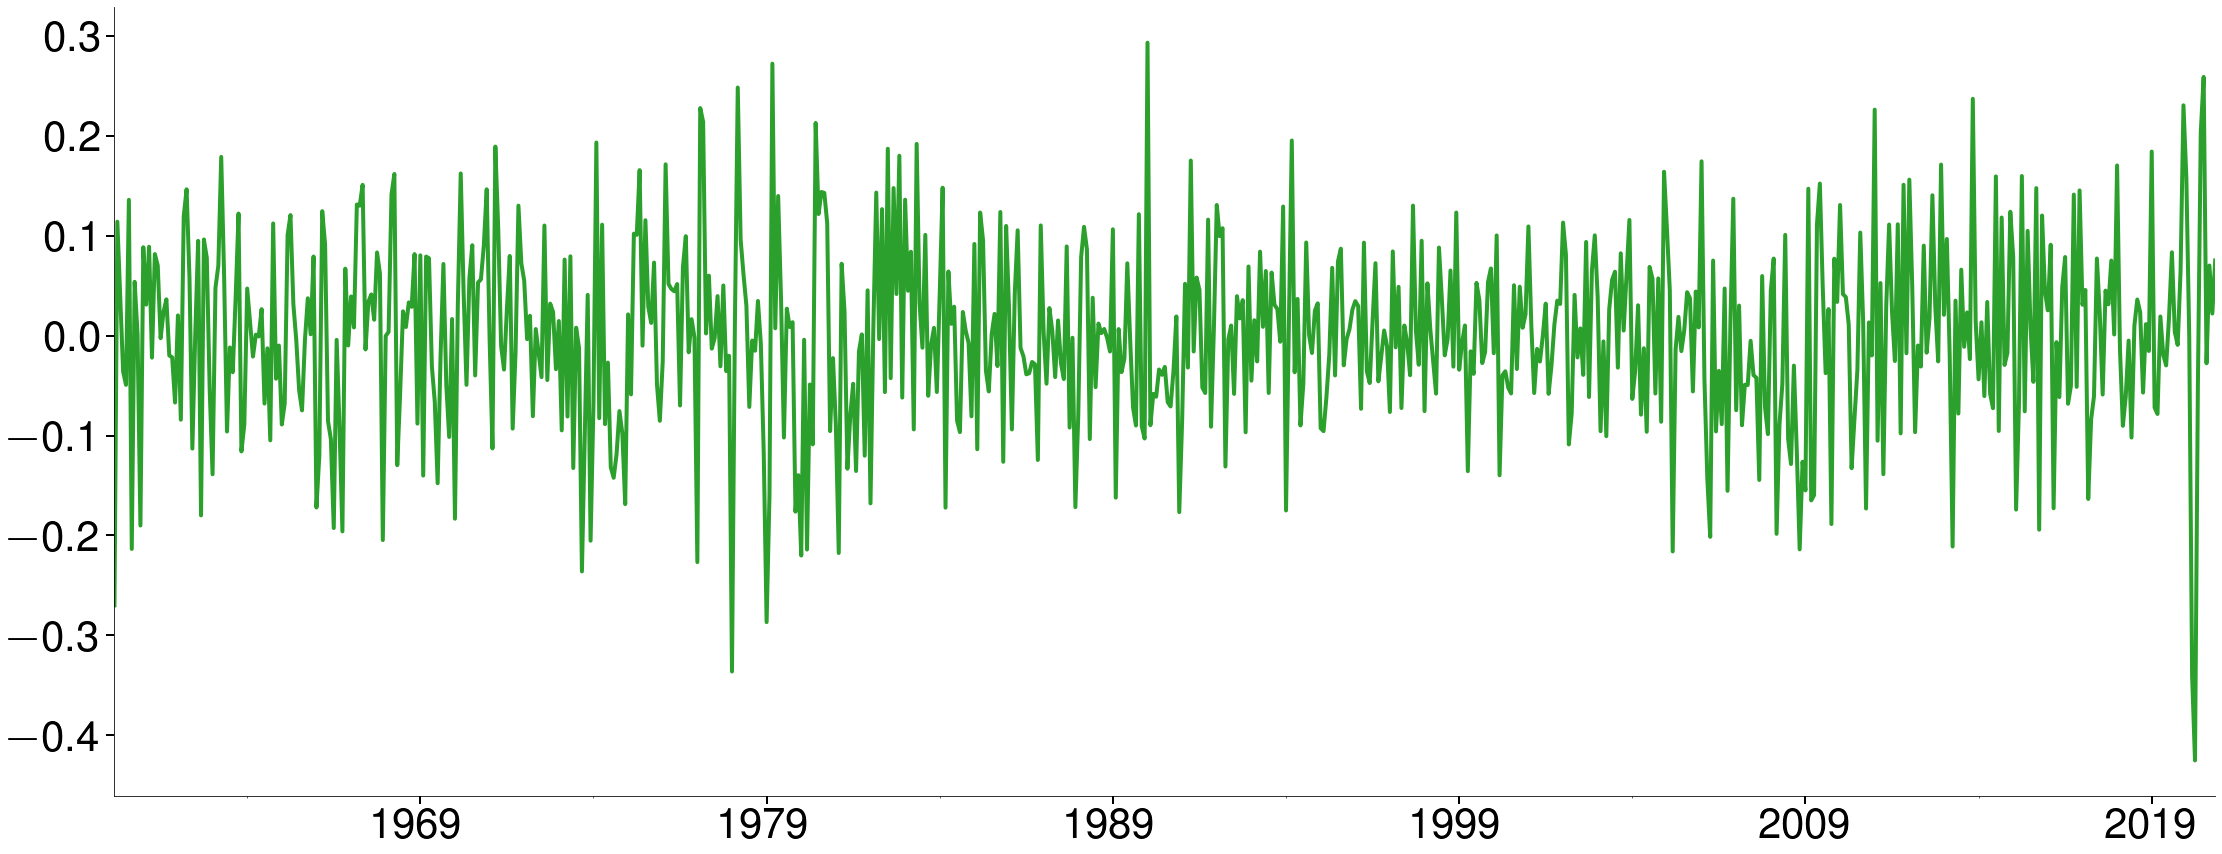

In [20]:
resid = res.resid.iloc[2:]
plot(resid, y=-2)

# Seasonal Dummy Model Residuals Diagnostics

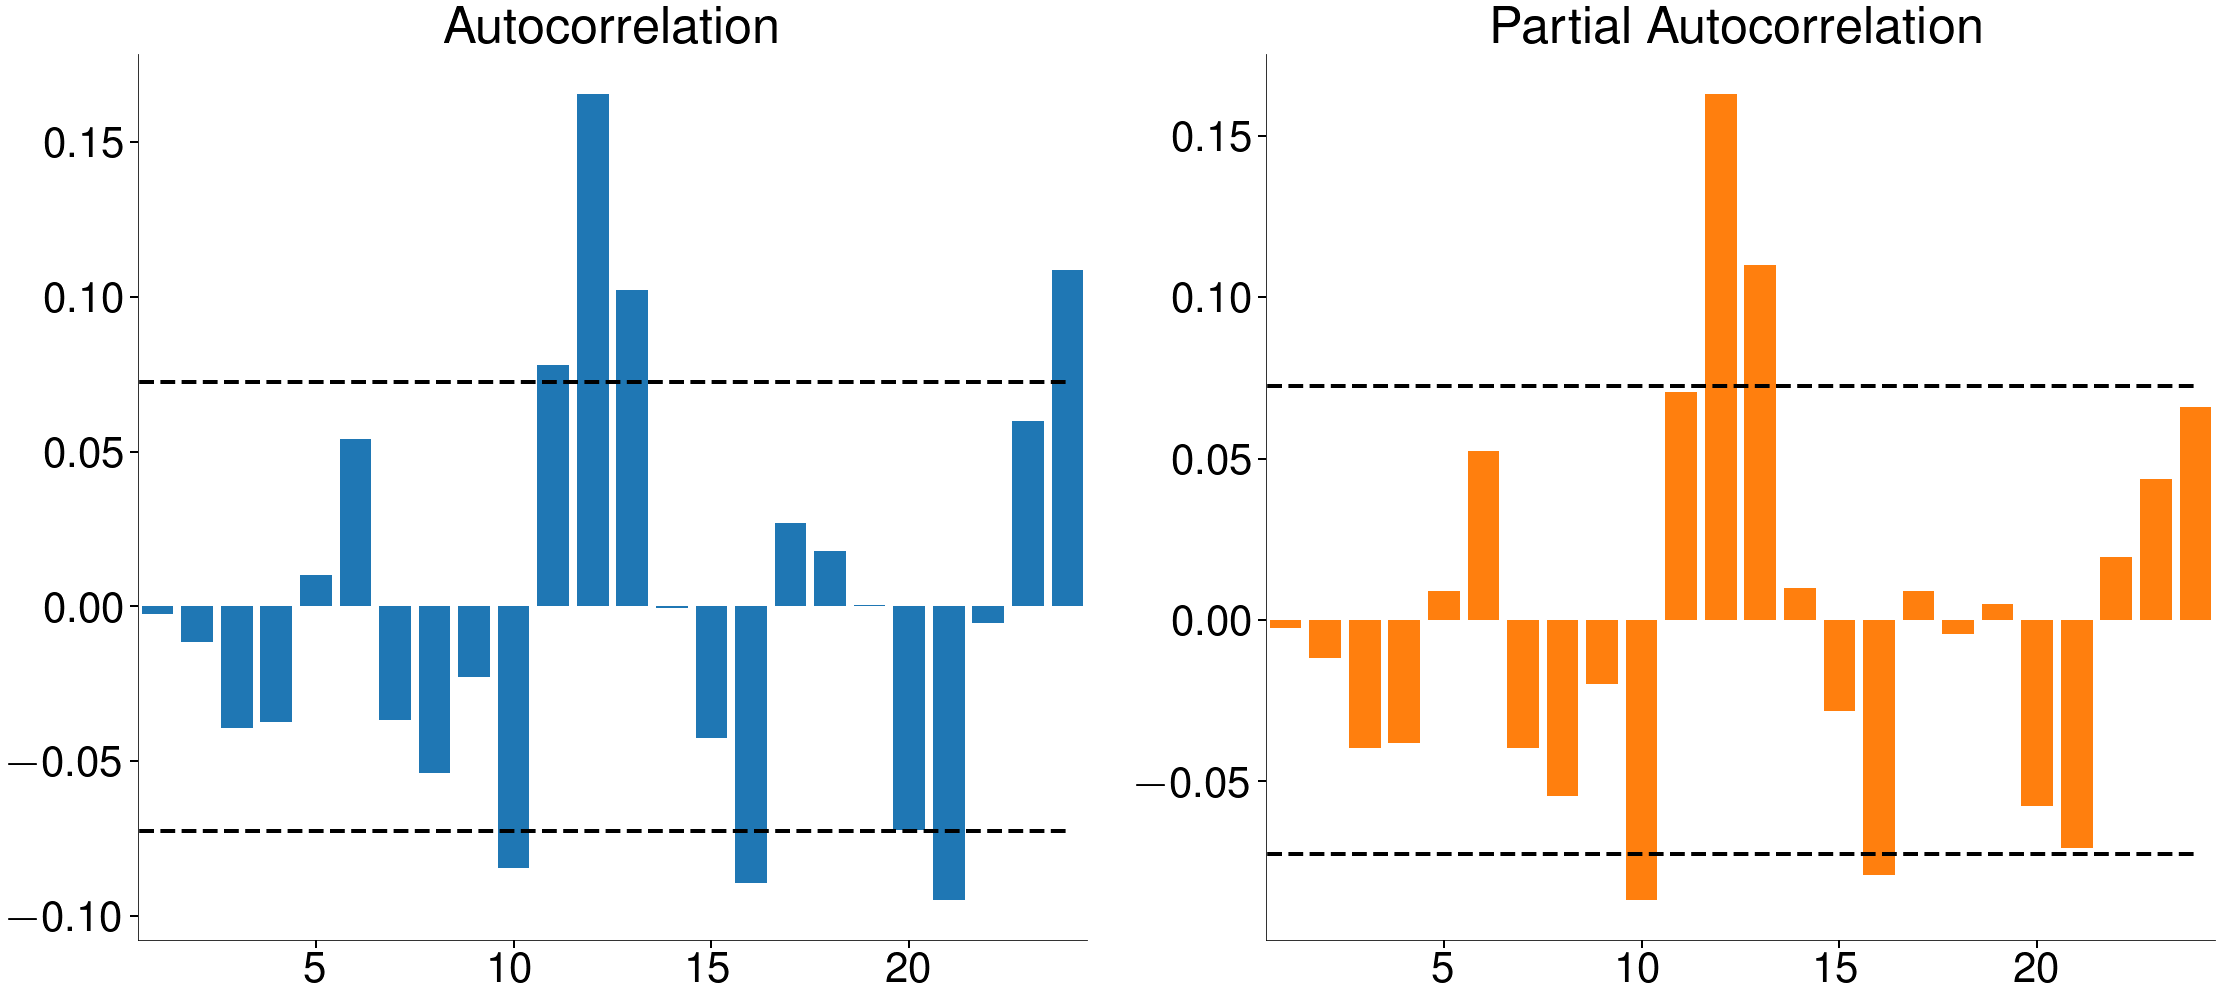

In [21]:
acf_pacf_plot(resid, 24)

# Unit Root Testing

* Test $Y_t$ for a unit root
* If null is not rejected, ensure that all required deterministic terms are included
* If null is still _not_ rejected, difference and test $\Delta Y_t$
* Positive $Y_t$ series should usually be transformed with $\ln$
* Select lag length of $\Delta Y_{t-j}$ terms using IC, usually AIC
* $H_0:\gamma=0$, $H_1:\gamma<0$

$$ Y_t = \delta_0 + \delta_1 t + \gamma Y_{t-1} + \sum_{i=1}^P \Delta Y_{t-i} + \epsilon_t $$

* Deterministic terms are needed to remove deterministic components from $Y_{t-1}$

In [22]:
from statsmodels.api import OLS
from statsmodels.nonparametric.kde import KDEUnivariate

rg = np.random.default_rng(20200101)


def adf_cv_plot():
    m = 2500
    y = np.cumsum(rg.standard_normal((300, m)), 0)[50:]
    y.shape
    adf_stats = np.empty((m, 3))
    for i in range(m):
        d = np.diff(y[:, i])
        x = y[:-1, i : i + 1]
        adf_stats[i, 0] = OLS(d, x).fit().tvalues[0]
        _x = np.column_stack([x, np.ones_like(x)])
        adf_stats[i, 1] = OLS(d, _x).fit().tvalues[0]
        _x = np.column_stack([_x, np.arange(x.shape[0])])
        adf_stats[i, 2] = OLS(d, _x).fit().tvalues[0]

    fig, ax = plt.subplots(1, 1)
    labels = ["No Deterministic", "Constant", "Constant and Trend"]
    x = []
    bnds = np.zeros(2)
    for i in range(3):
        kde = KDEUnivariate(adf_stats[:, i]).fit()
        bw = kde.bw
        kde = KDEUnivariate(adf_stats[:, i]).fit(bw=1.75 * bw)
        ax.plot(kde.support, kde.density, label=labels[i])
        bnds[0] = min(bnds[0], kde.support.min())
        bnds[1] = max(bnds[1], kde.support.max())
        right = np.where(kde.cdf < 0.05)[0][-1]
        ax.fill_between(
            kde.support[:right], np.zeros(right), kde.density[:right], alpha=0.33
        )
        x.append(kde.support)
    x = np.sort(np.hstack(x))
    pdf = stats.norm().pdf(x)
    ax.plot(x, pdf, label="Standard Normal")
    right = np.where(stats.norm().cdf(x) < 0.05)[0][-1]
    ax.fill_between(x[:right], np.zeros(right), pdf[:right], alpha=0.33)
    yl = ax.get_ylim()
    ax.set_ylim(0, yl[1])
    ax.set_xlim(bnds)
    fig.legend(frameon=False)
    sns.despine()
    fig.tight_layout(pad=1.0)

# The Dickey-Fuller distributions

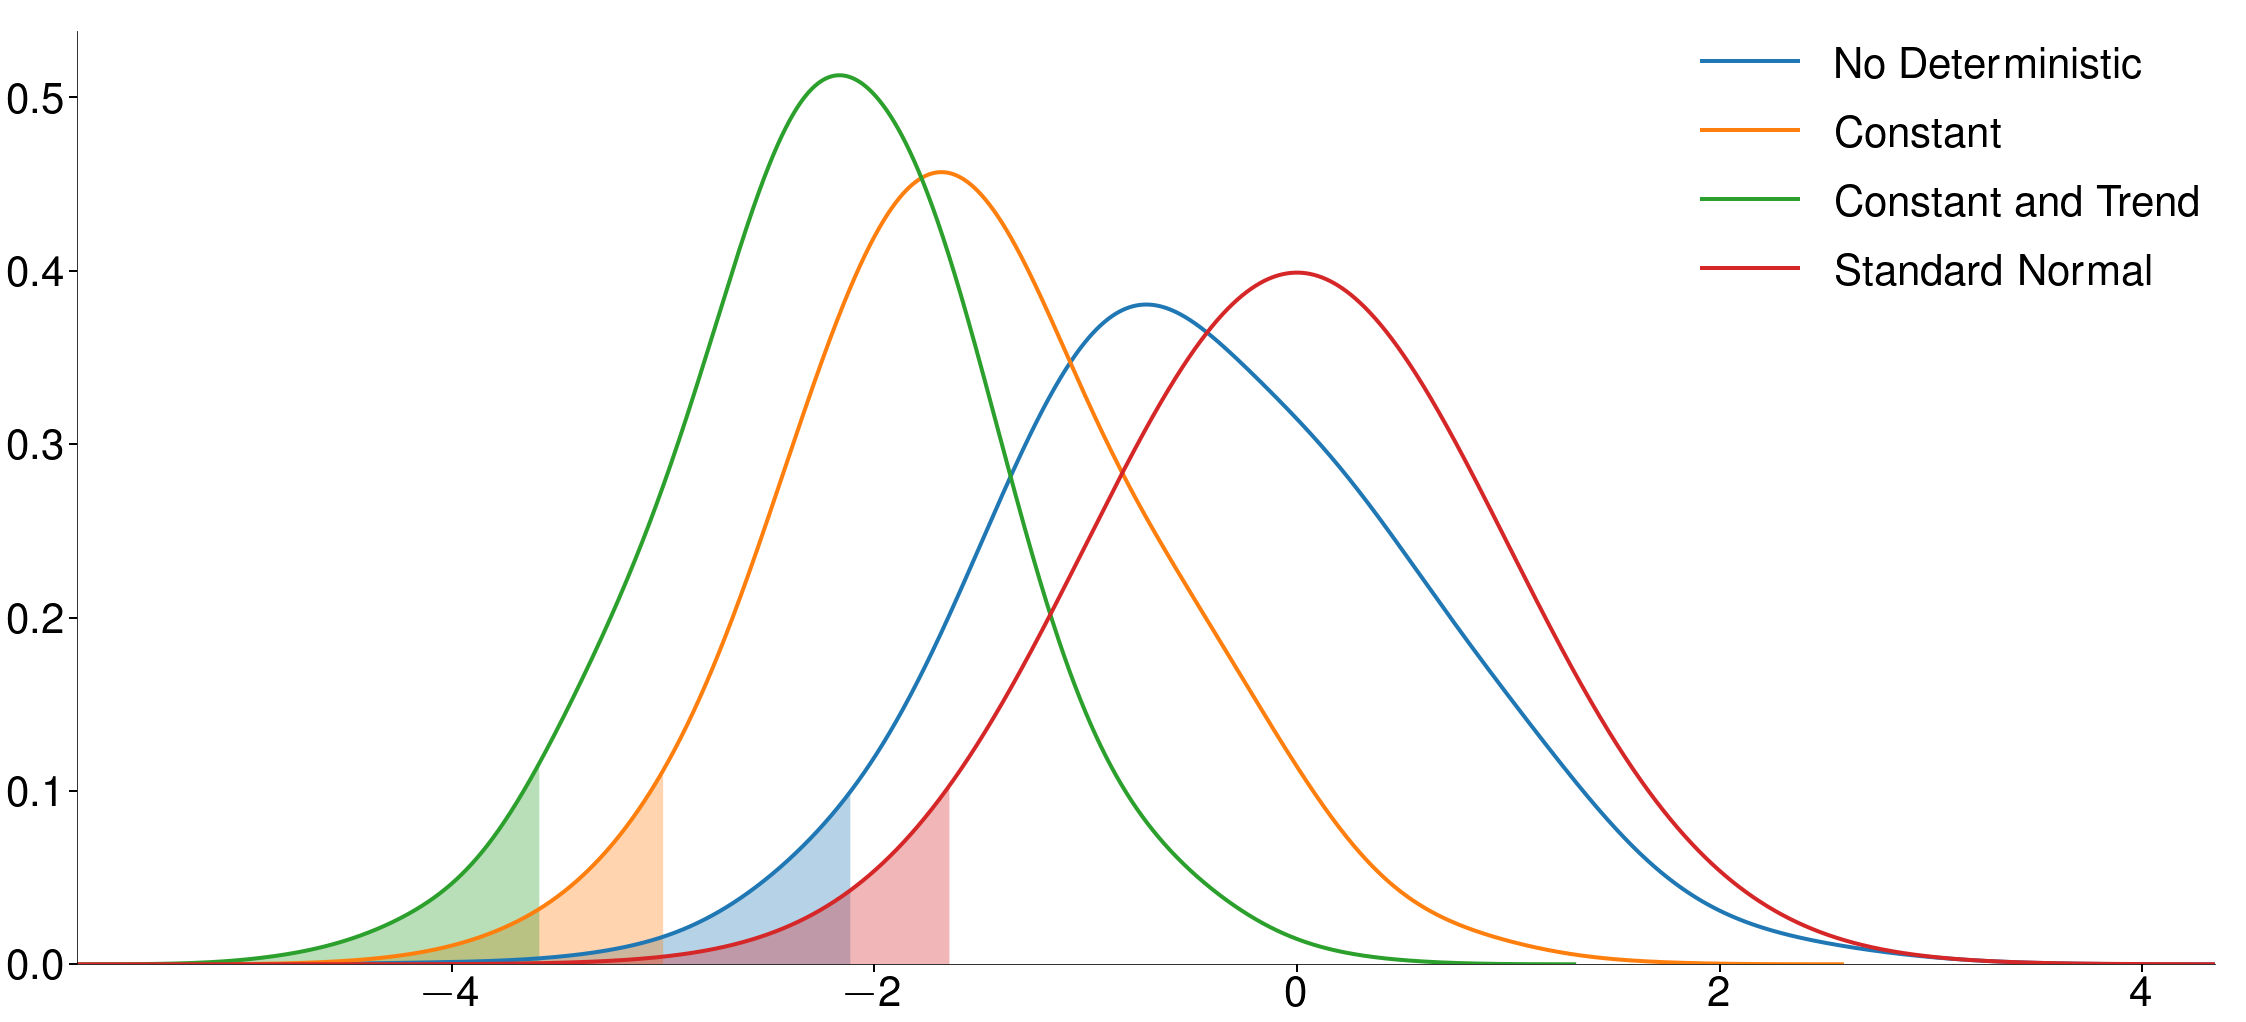

In [23]:
adf_cv_plot()

# Testing Default Premium

In [24]:
from arch.unitroot import ADF

adf = ADF(default)
adf.summary()

Test Statistic,-3.866
P-value,0.002
Lags,10


# Testing Curvature

In [25]:
adf = ADF(curve)
adf.summary()

Test Statistic,-4.412
P-value,0.000
Lags,19


# Testing Industrial Production

In [26]:
adf = ADF(np.log(orig.INDPRO), trend="c")
adf.summary()

Test Statistic,-2.186
P-value,0.211
Lags,4


# ADF Regression Results

In [27]:
summary(adf.regression)

,coef,std err,t,P>|t|,[0.025,0.975]
Level.L1,-0.0017,0.001,-2.186,0.029,-0.003,-0.000
Diff.L1,0.3637,0.037,9.860,0.000,0.291,0.436
Diff.L2,-0.1110,0.039,-2.832,0.005,-0.188,-0.034
Diff.L3,0.0447,0.039,1.138,0.255,-0.032,0.122
Diff.L4,0.0217,0.037,0.589,0.556,-0.051,0.094
const,0.0083,0.003,2.579,0.010,0.002,0.015


# Increasing the deterministic order

In [28]:
adf = ADF(np.log(orig.INDPRO), trend="ct")
adf

Test Statistic,-1.831
P-value,0.690
Lags,6


# Testing the difference

* The Industrial Productivity Index is $I(1)$ since 1 difference makes it stationary

In [29]:
delta_indpro = np.log(orig.INDPRO).diff().dropna()
adf = ADF(delta_indpro, trend="c")
adf

Test Statistic,-11.945
P-value,0.000
Lags,3


# The importance of time trends

* Incorrect trend specification results in no power to reject false nulls
* Always find a unit root in trending time series

In [30]:
y = np.zeros(250)
e = rg.standard_normal(250)
for i in range(250):
    y[i] = 0.025 * i + e[i]
    if i > 0:
        y[i] += 0.7 * y[i - 1]

trending = pd.Series(y, name="trending")

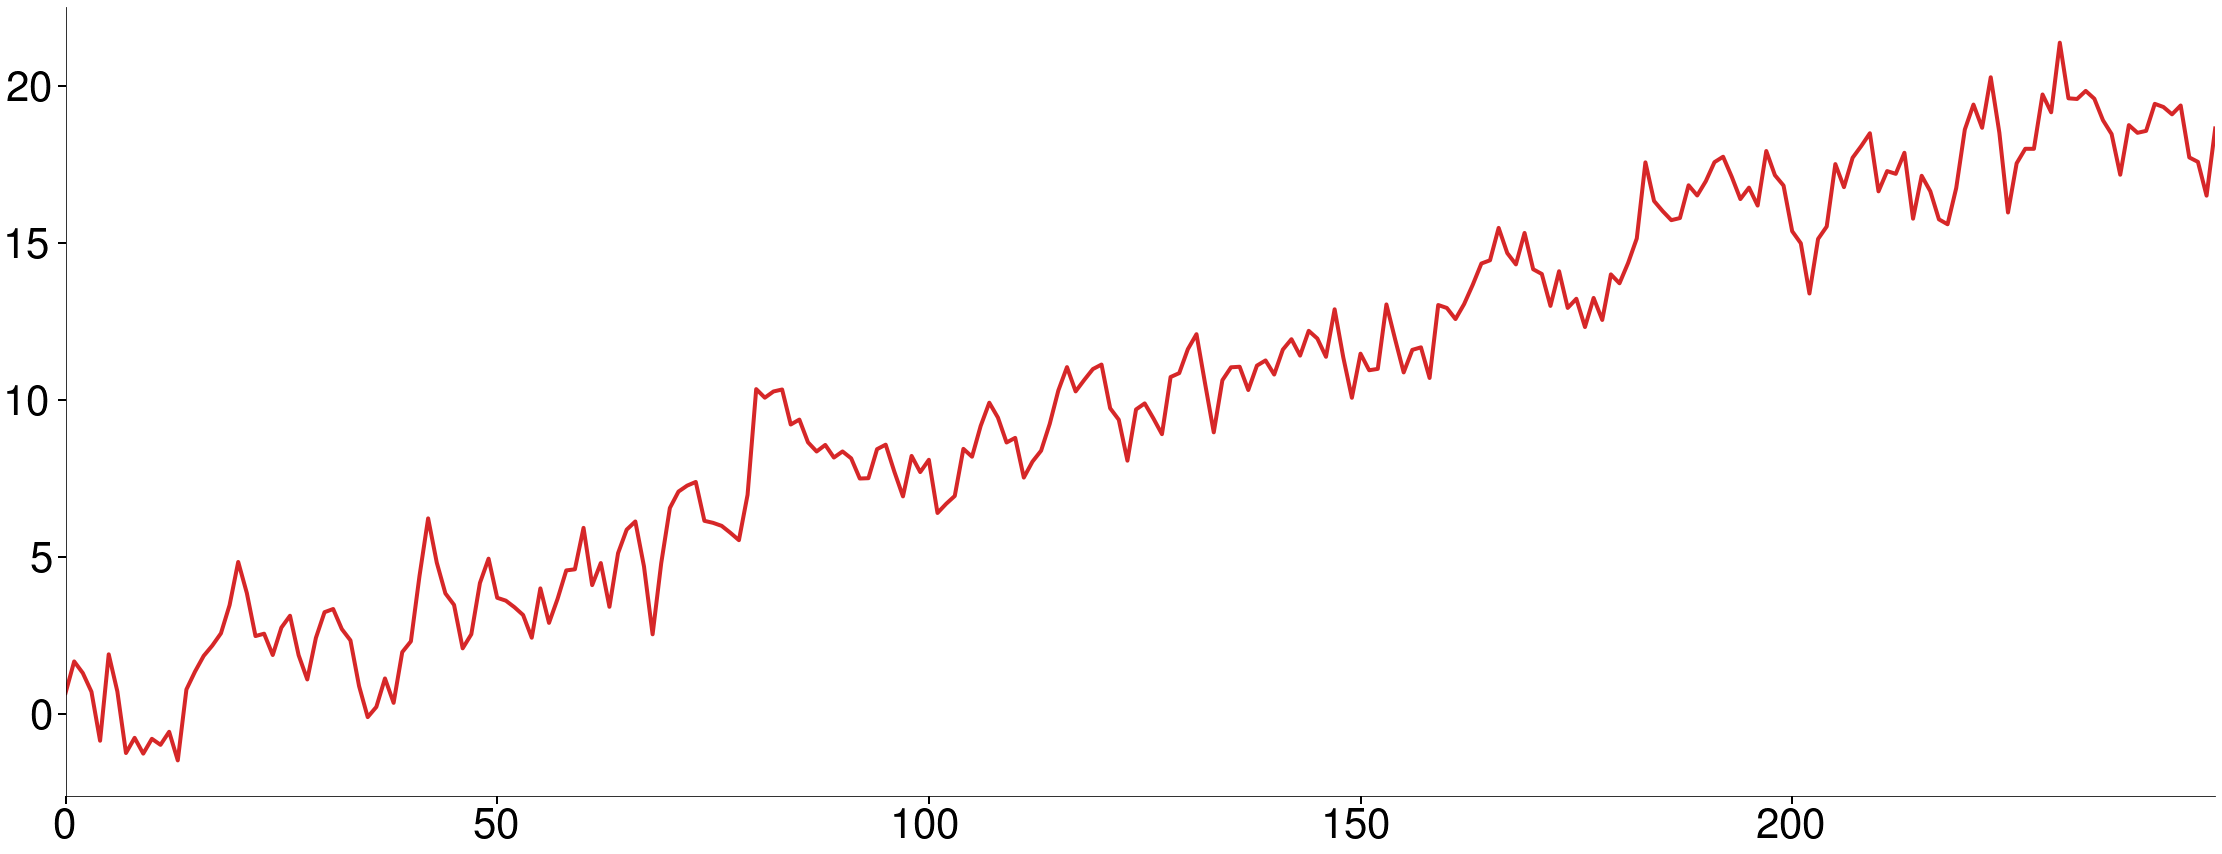

In [31]:
plot(trending, 13)

# Under-specifying Deterministic Terms

* Do not use model with no deterministic terms on real data unless $Y_t$ is known to be mean 0

In [32]:
ADF(trending, trend="n")

Test Statistic,1.934
P-value,0.988
Lags,9


# Under-specifying Deterministic Terms

In [33]:
ADF(trending, trend="c")

Test Statistic,-1.146
P-value,0.696
Lags,9


# Correctly specifying Deterministic Terms

In [34]:
ADF(trending, trend="ct")

Test Statistic,-6.790
P-value,0.000
Lags,0


# Over-specifying Deterministic Terms

In [35]:
ADF(y, trend="ctt")

Test Statistic,-6.885
P-value,0.000
Lags,0


# Incorporating Time Trends into ARMA Models

* Can jointly estimate trends and stationary components of ARMA models

$$ Y_t = \phi_0 + \delta_1 t + \phi_1 Y_{t-1} + \epsilon_t $$

In [36]:
res = SARIMAX(trending, order=(1, 0, 0), trend="ct").fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0796,0.116,0.687,0.492,-0.148,0.307
drift,0.0255,0.004,6.149,0.000,0.017,0.034
ar.L1,0.6822,0.050,13.534,0.000,0.583,0.781
sigma2,0.9213,0.080,11.451,0.000,0.764,1.079


# Time Trend Model Residuals

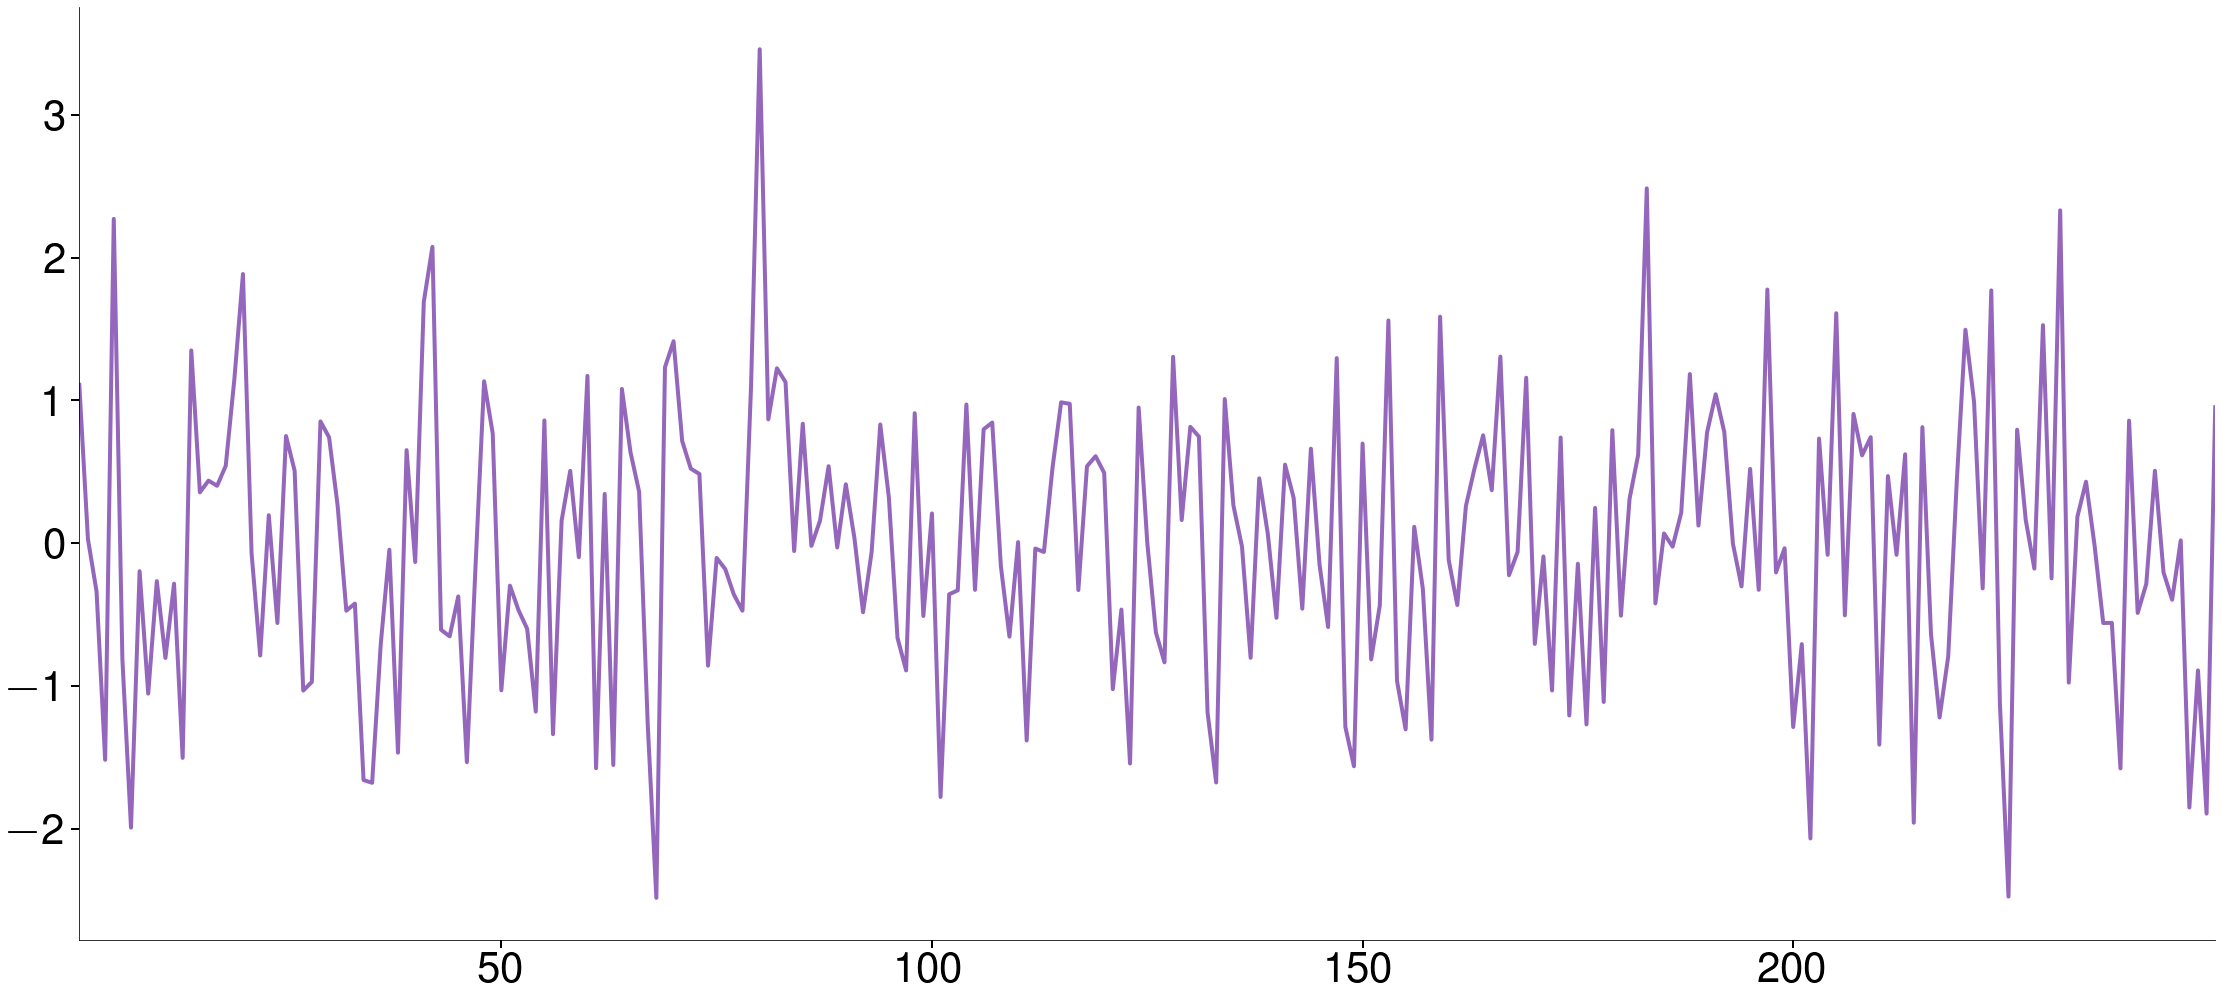

In [37]:
plot(res.resid.iloc[1:])

# Next Week

* Univariate Volatility Modeling